## Import

In [1]:
# ===== Standard Library =====
import pickle
from typing import List, Set, Tuple

# ===== Scientific Computing =====
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.spatial.distance import cdist

# ===== PyTorch Core =====
import torch
from torch import pi, sqrt
from torch.distributions.normal import Normal
from torch.quasirandom import SobolEngine

# ===== GPyTorch =====
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.priors import GammaPrior

# ===== BoTorch Core =====
from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms import Normalize, Standardize
from botorch.optim import optimize_acqf

# ===== BoTorch Acquisition & Sampling =====
from botorch.acquisition.multi_objective.logei import qLogExpectedHypervolumeImprovement
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.sampling.normal import SobolQMCNormalSampler

# ===== BoTorch Utilities =====
from botorch.utils.multi_objective.hypervolume import Hypervolume
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning

# ===== Pymoo (Evolutionary Algorithms) =====
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.lhs import LHS
# from pymoo.operators.sampling.random import RandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination import get_termination


c:\Users\n12046299\AppData\Local\anaconda3\envs\arbo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Benchmark class

In [2]:
from scipy.stats import norm

def lhs_uniform(n_samples, n_dims):
    """
    Generate Latin Hypercube Samples (LHS) from a uniform distribution.

    Args:
        n_samples (int): Number of samples.
        n_dims (int): Number of dimensions.

    Returns:
        torch.Tensor: LHS samples of shape (n_samples, n_dims) in [0, 1].
    """
    intervals = np.linspace(0, 1, n_samples + 1)[:-1]
    points = intervals + np.random.uniform(0, 1 / n_samples, n_samples)
    np.random.shuffle(points)
    # 'points' now has shape (n_samples,).
    # We reshape and expand to get final shape (n_samples, n_dims).
    lhs = torch.tensor(points).reshape(-1, 1).expand(n_samples, n_dims)
    return lhs

def _prepare_as_tensor(value, dim):
    """
    Convert the input 'value' (scalar, list, numpy array, or torch tensor)
    into a 1D torch.Tensor of shape (dim,).

    If 'value' is a scalar, replicate it for each dimension.
    If 'value' is a list or array, its length must match 'dim'.

    Args:
        value: A scalar, list, numpy array, or torch tensor indicating uncertainty
               parameters (mean or scale).
        dim (int): The required dimension size (e.g., x.shape[1]).

    Returns:
        torch.Tensor of shape (dim,).
    """
    def get_scalar(x):
        """Extract scalar value from various container types"""
        if isinstance(x, torch.Tensor):
            if x.numel() != 1:
                raise ValueError(f"Tensor must contain exactly 1 element, got {x.numel()}")
            return x.item()
        if isinstance(x, np.ndarray):
            if x.size != 1:
                raise ValueError(f"Array must contain exactly 1 element, got {x.size}")
            return x.item()
        return float(x)

    if isinstance(value, (int, float)):
        # Single scalar: replicate for each dimension
        return torch.full((dim,), float(value), dtype=torch.float64)
    elif isinstance(value, list):
        # List: must match 'dim'
        if len(value) == 1:
            # Handle [scalar], [tensor], or [array] cases
            scalar = get_scalar(value[0])
            return torch.full((dim,), scalar, dtype=torch.float64)
        elif len(value) != dim:
            raise ValueError(f"Expected a list of length {dim}, got {len(value)}")
        return torch.tensor(value, dtype=torch.float64)
    elif isinstance(value, np.ndarray):
        # NumPy array: must match 'dim'
        if value.ndim == 0:
            # Single scalar in numpy form
            return torch.full((dim,), float(value), dtype=torch.float64)
        if len(value) == 1:
            # Handle [scalar], [tensor], or [array] cases
            scalar = get_scalar(value[0])
            return torch.full((dim,), scalar, dtype=torch.float64)
        if value.shape[0] != dim:
            raise ValueError(f"Expected array of length {dim}, got {value.shape[0]}")
        return torch.tensor(value, dtype=torch.float64)
    elif isinstance(value, torch.Tensor):
        # Torch tensor: must match 'dim'
        if value.ndim == 0:
            # Single scalar in torch tensor form
            return torch.full((dim,), float(value.item()), dtype=torch.float64)
        if len(value) == 1:
            # Handle [scalar], [tensor], or [array] cases
            scalar = get_scalar(value[0])
            return torch.full((dim,), scalar, dtype=torch.float64)
        if value.shape[0] != dim:
            raise ValueError(f"Expected tensor of length {dim}, got {value.shape[0]}")
        return value.to(torch.float64)
    else:
        raise TypeError(
            "uncertainty_mean / uncertainty_scale must be scalar, list, np.ndarray, or torch.Tensor"
        )

def sample_data_with_uncertainty(
    x: torch.Tensor,
    f,
    sample_times: int = 10,
    uncertainty_mean=0,
    uncertainty_scale=0.05,
    lower_bound: torch.Tensor=None,
    upper_bound: torch.Tensor=None,
    strict_constrain: bool=False,
    # Which metrics to compute:
    compute_mean: bool=True,   # Bayes risk, i.e. the mean of f(x+noise)
    compute_std:  bool=True,
    compute_var:  bool=False,  # Value-at-Risk
    var_alpha:    float=0.95,
    compute_cvar: bool=False,  # Conditional Value-at-Risk
    cvar_alpha:   float=0.95,
    larger_is_worse: bool=True
):
    """
    Merges the Bayesian risk (integral of f under noise) with optional
    std, VaR, CVaR, all in one function. No PoE included.

    We'll draw 'sample_times' noise vectors for each x[i], evaluate f,
    and compute:

      - 'mean' = mean of samples (Bayes risk)
      - 'std'  = standard deviation of samples
      - 'VaR'  = alpha-quantile of samples (upper or lower tail)
      - 'CVaR' = average of samples in that tail.

    Args:
        x (torch.Tensor): shape (n_points, input_dim).
        f (callable): maps a single (input_dim,) to scalar or (output_dim,).
        sample_times (int): number of noise draws to approximate the integral.
        uncertainty_mean, uncertainty_scale: define p(noise).
        lower_bound, upper_bound (torch.Tensor): shapes (input_dim,). If strict_constrain,
            we clip each x+noise to [lower_bound, upper_bound].
        compute_mean (bool): if True, compute the Monte Carlo mean = Bayes risk.
        compute_std  (bool): if True, compute the sample standard deviation of outputs.
        compute_var  (bool): if True, compute Value-at-Risk at var_alpha.
        compute_cvar (bool): if True, compute CVaR at cvar_alpha.
        var_alpha, cvar_alpha (float in (0,1)): quantile levels.
        larger_is_worse (bool): if True, we interpret the 'bad' tail to be the top tail
                                for VaR/CVaR. If False, the bottom tail.

    Returns:
        dict with:
          'x': shape (n_points, input_dim)
          'mean': (n_points, output_dim) if compute_mean=True
          'std':  (n_points, output_dim) if compute_std=True and sample_times>1
          'VaR':  (n_points, output_dim) if compute_var=True
          'CVaR': (n_points, output_dim) if compute_cvar=True
    """
    # Handle 1D tensor by adding a dimension
    if x.ndim == 1:
        x = x.unsqueeze(0)

    if x.ndim != 2:
        raise ValueError(f"x should be a 2D tensor, got shape {x.shape}.")

    n_points, input_dim = x.shape

    # Setup the noise distribution
    unc_mean  = _prepare_as_tensor(uncertainty_mean,  input_dim)
    unc_scale = _prepare_as_tensor(uncertainty_scale, input_dim)
    unc_scale = torch.abs(unc_scale)

    # We'll do a small helper for VaR, CVaR:
    def compute_var_cvar_1d(values: torch.Tensor, alpha: float, top_tail: bool):
        """
        Compute Value-at-Risk and CVaR for a 1D vector of samples.
        If top_tail=True => we look at the upper tail for alpha quantile.
        """
        sorted_vals = torch.sort(values)[0]  # ascending
        N = len(sorted_vals)
        idx_float = alpha * N

        if top_tail:
            # e.g. alpha=0.95 => 95% near top
            # index from bottom = N - alpha*N
            i_bottom = N - idx_float
            idx_ceil = int(torch.ceil(torch.tensor(i_bottom))) - 1
            idx_ceil = max(0, min(idx_ceil, N - 1))
            var_val = sorted_vals[idx_ceil]  # the alpha quantile from top
            tail_vals = sorted_vals[idx_ceil:]
            cvar_val = tail_vals.mean() if len(tail_vals) > 0 else var_val
        else:
            # lower tail
            idx_ceil = int(torch.ceil(torch.tensor(idx_float))) - 1
            idx_ceil = max(0, min(idx_ceil, N-1))
            var_val = sorted_vals[idx_ceil]
            tail_vals = sorted_vals[:idx_ceil+1]
            cvar_val = tail_vals.mean() if len(tail_vals) > 0 else var_val

        return var_val, cvar_val

    # We'll store the results in lists, then stack at the end
    mean_list   = [] if compute_mean else None
    std_list    = [] if compute_std  else None
    var_list    = [] if compute_var  else None
    cvar_list   = [] if compute_cvar else None

    for xi in x:
        # Draw sample_times noisy samples
        lhs_samples = lhs_uniform(sample_times, input_dim).numpy()
        gauss_noise = np.zeros_like(lhs_samples, dtype=np.float64)

        # dimension by dimension
        for d in range(input_dim):
            gauss_noise[:, d] = norm.ppf(
                lhs_samples[:, d],
                loc=unc_mean[d].item(),
                scale=unc_scale[d].item()
            )

        gauss_noise = torch.tensor(gauss_noise, dtype=torch.float64)

        outputs = []
        for noise_vec in gauss_noise:
            x_noisy = xi + noise_vec
            if strict_constrain:
                if lower_bound is not None:
                    x_noisy = torch.max(x_noisy, lower_bound)
                if upper_bound is not None:
                    x_noisy = torch.min(x_noisy, upper_bound)
            y_val = f(x_noisy).squeeze()
            outputs.append(y_val)

        outputs = torch.stack(outputs, dim=0)  # shape (sample_times, ?)
        if outputs.dim() == 1:
            # means scalar => shape (sample_times,) => turn it to (sample_times,1)
            outputs = outputs.unsqueeze(-1)

        # shape => (sample_times, output_dim)
        out_dim = outputs.shape[1]

        # 1) risk = mean
        if compute_mean:
            # "Bayes risk" is the average of f(x_noisy)
            mean_i = torch.mean(outputs, dim=0)  # shape (output_dim,)
        # 2) std
        if compute_std and sample_times > 1:
            std_i  = torch.std(outputs, dim=0)
        # 3) VaR, CVaR dimension by dimension
        if compute_var or compute_cvar:
            var_dim  = []
            cvar_dim = []
            for j in range(out_dim):
                v_j, c_j = compute_var_cvar_1d(
                    outputs[:, j],
                    alpha=var_alpha if compute_var else cvar_alpha,
                    top_tail=larger_is_worse
                )
                var_dim.append(v_j)
                cvar_dim.append(c_j)
            var_i  = torch.stack(var_dim,  dim=0) if compute_var  else None
            cvar_i = torch.stack(cvar_dim, dim=0) if compute_cvar else None

        # store
        if compute_mean:
            mean_list.append(mean_i)
        if compute_std and sample_times>1:
            std_list.append(std_i)
        if compute_var:
            var_list.append(var_i)
        if compute_cvar:
            cvar_list.append(cvar_i)

    # Build final output
    results = {
        'x': x
    }
    if compute_mean:
        results['mean'] = torch.stack(mean_list, dim=0)  # shape (n_points, output_dim)
    if compute_std and sample_times>1:
        results['std']  = torch.stack(std_list, dim=0)
    if compute_var:
        results['VaR']  = torch.stack(var_list, dim=0)
    if compute_cvar:
        results['CVaR'] = torch.stack(cvar_list, dim=0)

    return results

In [3]:
def is_pareto(costs: torch.Tensor, epsilon: float = 1e-5) -> torch.Tensor:
    """
    Identifies the Pareto-efficient points among a set of costs with a tolerance.
    For 2D minimization, pass -costs instead.

    Args:
        costs (torch.Tensor): shape (n_points, n_objectives).
                              Each row is an objective vector.
        epsilon (float): Small tolerance to allow near-Pareto solutions.

    Returns:
        torch.Tensor: A boolean mask of shape (n_points,) where True indicates a Pareto point.
    """
    # Get the strict Pareto front
    n = costs.shape[0]
    is_efficient = torch.ones(n, dtype=torch.bool, device=costs.device)
    for i in range(n):
        if is_efficient[i]:
            dominated = torch.all(costs <= costs[i], dim=1) & torch.any(costs < costs[i], dim=1)
            is_efficient[dominated] = False

    pareto_Y = costs[is_efficient]

    # Apply tolerance to allow near-Pareto solutions
    relaxed_efficient = torch.tensor([
        any(torch.all(torch.abs(y - p) <= epsilon * torch.abs(p)) for p in pareto_Y)
        for y in costs
    ], dtype=torch.bool, device=costs.device)

    return relaxed_efficient

class MultiObjectiveBenchmark:
    def __init__(self, num_objectives, num_variables):
        self.num_objectives = num_objectives
        self.num_variables = num_variables

    def gen_groundtruth_pareto_front(self, pop_size=60, n_gen=200):
        """
        Apply exhaustive NSGA-II search with a population size of 60 to generate the reference Pareto front.

        Args:
            pop_size (int): Population size for NSGA-II algorithm
            n_gen (int): Number of generations for NSGA-II algorithm

        Returns:
            tuple: (X_pareto, Y_pareto) where:
                X_pareto is tensor of Pareto optimal decision variables
                Y_pareto is tensor of corresponding objective values
        """
        class BenchmarkProblem(Problem):
            def __init__(self, benchmark):
                super().__init__(n_var=benchmark.num_variables, n_obj=benchmark.num_objectives,
                                xl=benchmark.lower_bound.numpy(), xu=benchmark.upper_bound.numpy())
                self.benchmark = benchmark

            def _evaluate(self, X, out, *args, **kwargs):
                out["F"] = self.benchmark.evaluate(
                    torch.tensor(X, dtype=torch.float64),
                )['mean'].numpy()

        problem = BenchmarkProblem(self)

        algorithm = NSGA2(
            pop_size=pop_size,
            sampling=LHS(),
            crossover=SBX(),
            mutation=PM(),
            eliminate_duplicates=True
        )

        res = minimize(problem,
                       algorithm,
                       get_termination("n_gen", n_gen),
                       verbose=False)

        X_pareto = torch.tensor(res.X, dtype=torch.float64)
        Y_pareto = torch.tensor(res.F, dtype=torch.float64)

        # Store results as class attributes
        self.groundtruth_pf_loc = X_pareto
        self.groundtruth_pf = Y_pareto

        print("Reference Pareto Front Computed using NSGA-II")

    def _transform_back(self, x_norm):
        """
        Transform normalized input from [0,1] back to the actual domain.
        Since ZDT functions are defined on [0,1], this is a no-op.

        Args:
            x_norm (torch.Tensor): shape (n_samples, num_variables)
                                    normalized input in [0,1].

        Returns:
            torch.Tensor: shape same as x_norm, values in [lower_bound, upper_bound].
        """
        return self.lower_bound + x_norm * (self.upper_bound - self.lower_bound)

    def evaluate(self, decision_variables):
        """
        Evaluate the ZDT1 objective values at the given normalized decision_variables.
        1) Transform from normalized space [0,1] to actual domain [0,1] (or other if changed).
        2) Call f(X) to compute objectives.
        """
        if not isinstance(decision_variables, torch.Tensor):
            decision_variables = torch.tensor(decision_variables, dtype=torch.float64)

        x_actual = self._transform_back(decision_variables)

        return {'x':decision_variables, 'mean': self.f(x_actual)}

    def evaluate_with_uncertainty(
        self,
        x,
        sample_times=10,
        uncertainty_mean=0.0,
        uncertainty_scale=0.05,
        strict_constrain=False,
        # Which metrics to compute:
        compute_mean: bool=True,   # Bayes risk, i.e. the mean of f(x+noise)
        compute_std:  bool=True,
        compute_var:  bool=False,  # Value-at-Risk
        var_alpha:    float=0.95,
        compute_cvar: bool=False,  # Conditional Value-at-Risk
        cvar_alpha:   float=0.95,
        larger_is_worse: bool=True
    ):
        """
        Evaluate the objective(s) with uncertainty for the given normalized input x in [0,1].
        Internally uses 'sample_data_with_uncertainty_nd_lhs'.

        Args:
            x (torch.Tensor): shape (n_samples, 1) or (n_samples,) in [0,1].
            sample_times (int): number of noise samples per input.
            uncertainty_mean (float/list): mean(s) of noise.
            uncertainty_scale (float/list): std dev(s) of noise.
            strict_constrain (bool): if True, clip (x + noise) to [0,1].

        Returns:
            dict with 'mean' and 'std' of shape (n_samples, 2).
        """
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float64)

        # Define a wrapper function that:
        # 1) transforms from [0,1] to the actual domain
        # 2) evaluates sinlinforrester
        def f_wrapper(x_norm):
            x_actual = self._transform_back(x_norm)
            return self.f(x_actual)
        if torch.all(uncertainty_scale == 0.):
            results = self.evaluate(x)
            # print(y.shape)
            # results = {'x': x,
            #            'mean':  y}
            print('successfully evaluate')
        # Use the sampling function
        if torch.all(uncertainty_scale != 0.):
            results = sample_data_with_uncertainty(
                x=x,
                f=f_wrapper,
                sample_times=sample_times,
                uncertainty_mean=uncertainty_mean,
                uncertainty_scale=uncertainty_scale,
                lower_bound=torch.tensor([0.0], dtype=torch.float64),
                upper_bound=torch.tensor([1.0], dtype=torch.float64),
                strict_constrain=strict_constrain,
                compute_mean=compute_mean,
                compute_std=compute_std,
                compute_var=compute_var,  # Value-at-Risk
                var_alpha=var_alpha,
                compute_cvar=compute_cvar,  # Conditional Value-at-Risk
                cvar_alpha=cvar_alpha,
                larger_is_worse=larger_is_worse
            )
        return results

In [4]:
class SinLinForrester(MultiObjectiveBenchmark):
    """
    A multi-objective benchmark combining sinusoidal and Forrester-like functions.
    Domain is [0,1] for each decision variable (here 1D).
    """

    def __init__(self, num_objectives=2, num_variables=1):
        super().__init__(num_objectives, num_variables)
        
        # Here we assume the domain is [0,1].
        # If you later change the actual domain, 
        # just update these values (and the transform_back method).
        self.lower_bound = torch.tensor([0.0])
        self.upper_bound = torch.tensor([1.0])

    @staticmethod
    def f(X):
        """
        Compute the Sinusoidal and Linear ForresteACr objectives for a given input tensor.

        Args:
            X (torch.Tensor): shape (n_samples, 1) or (1,).
                              Each row or single value represents a single input x.

        Returns:
            torch.Tensor:
                - If X is shape (n_samples, 1), returns shape (n_samples, 2).
                - If X is shape (1,), returns shape (2,).
        """
        if X.dim() == 1 and X.shape[0] == 1:
            # Single input: X.shape == (1,)
            x = X[0]
            y1 = torch.sin(5 * pi * x**2) + 0.5 * x
            y2 = (6 * x - 2)**2 * torch.sin(12 * x - 4)
            return torch.tensor([y1, y2], dtype=X.dtype)
        elif X.dim() == 2 and X.shape[1] == 1:
            # Batched input: X.shape == (n_samples, 1)
            x = X[:, 0]
            y1 = torch.sin(5 * pi * x**2) + 0.5 * x
            y2 = (6 * x - 2)**2 * torch.sin(12 * x - 4)
            return torch.stack((y1, y2), dim=1)  # (n_samples, 2)
        else:
            raise ValueError("Input tensor must have shape (1,) or (n_samples, 1).")

    def _transform_back(self, x_norm):
        """
        Transform normalized input from [0,1] back to the actual domain.
        Here, the domain is also [0,1], so it's effectively a no-op,
        but we write this method for clarity and future extensibility.

        Args:
            x_norm (torch.Tensor): shape (n_samples, 1) or (1,)
                                   normalized input in [0,1].

        Returns:
            torch.Tensor: shape same as x_norm, values in [lower_bound, upper_bound].
        """
        return self.lower_bound + x_norm * (self.upper_bound - self.lower_bound)

    def evaluate(self, decision_variables):
        """
        Evaluate the true objective values at the given normalized decision_variables.
        1) Transform from normalized space [0,1] to actual domain [0,1] (or other if changed).
        2) Call sinlinforrester.
        """
        # Ensure decision_variables is a torch.Tensor
        if not isinstance(decision_variables, torch.Tensor):
            decision_variables = torch.tensor(decision_variables, dtype=torch.float64)

        # Transform from [0,1] to [lower_bound, upper_bound]
        x_actual = self._transform_back(decision_variables)

        # Evaluate the function
        return {'x': decision_variables, 'mean': self.f(x_actual)}
    
    def evaluate_with_uncertainty(self, x, sample_times=10, uncertainty_mean=0, uncertainty_scale=0.05, strict_constrain=False, compute_mean = True, compute_std = True, compute_var = False, var_alpha = 0.95, compute_cvar = False, cvar_alpha = 0.95, larger_is_worse = True):
        return super().evaluate_with_uncertainty(x, sample_times, uncertainty_mean, uncertainty_scale, strict_constrain, compute_mean, compute_std, compute_var, var_alpha, compute_cvar, cvar_alpha, larger_is_worse)


## Optimisation process

In [5]:
def compute_2d_hypervolume(front: torch.Tensor, ref_point: torch.Tensor) -> float:
    """
    Computes the 2D hypervolume for a Pareto front in *normalized* space [0,1]^2,
    from 'front' up to 'ref_point' (which must be worse/larger for a minimization scenario).
    The 'front' is assumed sorted in ascending order of objective 0.

    Args:
        front (torch.Tensor): shape (k, 2). Each row is a point in 2D minimization objective space.
        ref_point (torch.Tensor): shape (2,), the corner bounding box for HV computation.

    Returns:
        float: The hypervolume measure in 2D.
    """
    hv = 0.0
    prev_h1 = ref_point[1].item()
    for i in range(len(front)):
        h0, h1 = front[i]
        if ref_point[0].item() < h0.item() and prev_h1 < h1.item():
            hv+=0
        else:
            hv += (ref_point[0].item() - h0.item()) * (prev_h1 - h1.item())
            prev_h1 = h1.item()
    return hv

In [ ]:
class RobustOptimisation():
    def __init__(self, benchmark, sample_time, signs, bounds=None, uncertainty=torch.tensor([[0, 1]])):
        # Initialize the benchmark and related parameters.
        self.benchmark = benchmark()
        self.sample_time = sample_time
        # Use objective_signs to be consistent with usage in run/step.
        if bounds is not None:
            self.lower_bound = bounds[:, 0]
            self.upper_bound = bounds[:, 1]
            self.benchmark.lower_bound = self.lower_bound
            self.benchmark.upper_bound = self.upper_bound
        else:
            self.lower_bound = self.benchmark.lower_bound
            self.upper_bound = self.benchmark.upper_bound
        # The uncertainty tensor is assumed to have two columns:
        # the first for the mean offset and the second for the std.
        self.uncertainty_mu = uncertainty[:, 0]
        self.uncertainty_sigma = uncertainty[:, 1]
        self.num_variables = self.benchmark.num_variables
        self.num_objectives = self.benchmark.num_objectives
        self.signs = signs
        self.objective_signs = torch.tensor(
            [-1.0 if sign == 'min' else 1.0 for sign in self.signs],
            dtype=torch.float64
        )

    ## GP related
    def set_GP_parameters(self, model_names=None, kernel_params=None,
                      use_normalize=True, use_standardize=True, optimize_hyperparams=True):
        """
        Set and store GP model parameters without building models.
        These parameters will be used when build_GP_models is called.

        Parameters
        ----------
        model_names : list[str], optional
            Names to identify each GP model. If None, defaults will be used.
        kernel_params : list[dict], optional
            List of dictionaries specifying kernel parameters for each model.
            Each dict can contain:
            - 'nu': Smoothness parameter for Matérn kernel (default: 2.5)
            - 'lengthscale': Initial lengthscale value (default: 0.25)
            - 'kernel_type': Type of kernel to use ('matern', 'rbf', etc.) (default: 'matern')
            - 'output_scale': Initial output scale (default: None)
            - 'noise': Initial noise level (default: None)
        use_normalize : bool, optional
            Whether to use input normalization (default: True).
        use_standardize : bool, optional
            Whether to standardize outputs (default: True).
        optimize_hyperparams : bool, optional
            Whether to optimize hyperparameters using MLL (default: True).
        """
        # Initialize storage for model parameters if not already created
        if not hasattr(self, 'stored_model_params'):
            self.stored_model_params = {
                'model_names': [],
                'kernel_params': [],
                'use_normalize': True,
                'use_standardize': True,
                'optimize_hyperparams': True
            }

        # Update global parameters
        if use_normalize is not None:
            self.stored_model_params['use_normalize'] = use_normalize

        if use_standardize is not None:
            self.stored_model_params['use_standardize'] = use_standardize

        if optimize_hyperparams is not None:
            self.stored_model_params['optimize_hyperparams'] = optimize_hyperparams

        # Update model-specific parameters if provided
        if model_names is not None:
            self.stored_model_params['model_names'] = model_names

        if kernel_params is not None:
            self.stored_model_params['kernel_params'] = kernel_params

        # Print confirmation
        print(f"GP parameters stored. Will be applied when build_GP_models is called.")
        print(f"Global settings: normalize={self.stored_model_params['use_normalize']}, "
            f"standardize={self.stored_model_params['use_standardize']}, "
            f"optimize={self.stored_model_params['optimize_hyperparams']}")

        if model_names:
            print(f"Stored {len(model_names)} model configurations")

    def build_GP_models(self, X, Y_list):
        """
        Build SingleTaskGP models using previously stored parameters.
        If no parameters were stored, uses defaults.

        Parameters
        ----------
        X : torch.Tensor
            Training inputs of shape (n_samples, d).
        Y_list : list[torch.Tensor]
            List of training targets; each element is shape (n_samples,)
            or (n_samples, 1) for one objective.
        """
        self.gp_models = []
        self.model_names = []
        self.model_params = []

        # Get stored parameters if available
        if hasattr(self, 'stored_model_params'):
            stored = self.stored_model_params
            model_names = stored.get('model_names', [])
            kernel_params = stored.get('kernel_params', [])
            use_normalize = stored.get('use_normalize', True)
            use_standardize = stored.get('use_standardize', True)
            optimize_hyperparams = stored.get('optimize_hyperparams', True)
        else:
            model_names = []
            kernel_params = []
            use_normalize = True
            use_standardize = True
            optimize_hyperparams = True

        # Set default model names if not provided
        if not model_names:
            model_names = [f"GP_obj{i+1}" for i in range(len(Y_list))]

        # Set default kernel parameters if not provided
        if not kernel_params:
            kernel_params = [{'nu': 2.5, 'lengthscale': 0.25, 'kernel_type': 'matern'}
                            for _ in range(len(Y_list))]

        # Ensure we have enough parameter sets
        if len(model_names) < len(Y_list):
            # Extend model names if needed
            additional = len(Y_list) - len(model_names)
            model_names.extend([f"GP_obj{i+len(model_names)+1}" for i in range(additional)])

        if len(kernel_params) < len(Y_list):
            # Extend kernel params if needed
            additional = len(Y_list) - len(kernel_params)
            kernel_params.extend([{'nu': 2.5, 'lengthscale': 0.25, 'kernel_type': 'matern'}
                                for _ in range(additional)])

        # Build models with parameters
        for i, (Y, name, params) in enumerate(zip(Y_list, model_names[:len(Y_list)],
                                                kernel_params[:len(Y_list)])):
            # Ensure Y has shape (n_samples, 1)
            Y = Y.view(-1, 1)

            # Get kernel parameters
            nu = params.get('nu', 2.5)
            lengthscale = params.get('lengthscale', 0.25)
            kernel_type = params.get('kernel_type', 'matern')
            output_scale = params.get('output_scale', None)
            noise = params.get('noise', None)

            # Select appropriate kernel based on kernel_type
            if kernel_type.lower() == 'matern':
                base_kernel = MaternKernel(nu=nu, ard_num_dims=self.num_variables)
            elif kernel_type.lower() == 'rbf':
                base_kernel = RBFKernel(ard_num_dims=self.num_variables)
            else:
                raise ValueError(f"Unsupported kernel type: {kernel_type}")

            # Create covariance module
            covar_module = ScaleKernel(base_kernel=base_kernel)

            # Initialize lengthscale
            covar_module.base_kernel.initialize(lengthscale=lengthscale)

            # Initialize output scale if provided
            if output_scale is not None:
                covar_module.initialize(outputscale=output_scale)

            # Set up input and outcome transforms
            input_transform = Normalize(d=self.num_variables) if use_normalize else None
            outcome_transform = Standardize(m=1) if use_standardize else None

            # Create GP model
            gp = SingleTaskGP(
                train_X=X,
                train_Y=Y,
                covar_module=covar_module,
                input_transform=input_transform,
                outcome_transform=outcome_transform,
            )

            # Set noise if provided
            # if noise is not None:
            #     gp.likelihood.initialize(noise=noise)

            # Optimize hyperparameters if requested
            if optimize_hyperparams:
                mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
                fit_gpytorch_mll(mll)

            # Store model and metadata
            self.gp_models.append(gp)
            self.model_names.append(name)

            # Record actual parameters used
            self.model_params.append({
                'kernel_type': kernel_type,
                'nu': nu if kernel_type == 'matern' else None,
                'lengthscale': gp.covar_module.base_kernel.lengthscale.detach().clone(),
                'output_scale': gp.covar_module.outputscale.detach().item(),
                'noise': gp.likelihood.noise.detach().item(),
                'use_normalize': use_normalize,
                'use_standardize': use_standardize,
                'optimize_hyperparams': optimize_hyperparams
            })

            # Print model information
            print(f"Built GP model '{name}' with {kernel_type} kernel")

    ## generate dataset
    def generate_X(self, initial_obs_num):
        # Generate Latin Hypercube samples in [0, 1]^d.
        sampler = qmc.LatinHypercube(d=self.benchmark.num_variables)
        lhs_samples = sampler.random(initial_obs_num)
        # NOTE: You might want to scale using self.lower_bound and self.upper_bound.
        scaled_samples = qmc.scale(lhs_samples, l_bounds=0, u_bounds=1)
        X = torch.tensor(scaled_samples, dtype=torch.float64)
        return X

    def generate_initial_dataset(self, initial_obs_num=None, X_init=None, Y_init_list=None, strict_constrain=False):
        self.strict_constrain = strict_constrain
        if X_init is None:
            X_init = self.generate_X(initial_obs_num)
            self.data = self.benchmark.evaluate_with_uncertainty(
                X_init,
                1,
                self.uncertainty_mu,
                self.uncertainty_sigma,
                strict_constrain
            )
        elif X_init is not None and Y_init_list is None:
            self.data = self.benchmark.evaluate_with_uncertainty(
                X_init,
                1,
                self.uncertainty_mu,
                self.uncertainty_sigma,
                strict_constrain
            )
        else:
            # Both initial X and Y are provided.
            self.data = {
                'x': X_init,
                'mean': Y_init_list[:, 0],  # Assumes Y_init_list shape is (n_samples, output_dim)
            }

    ## Ground truth Pareto Front
    def generate_reference_pareto_front(self):
        """
        Apply exhaustive NSGA-II search with a population size of 60 to generate the reference Pareto front.
        """
        self.benchmark.gen_groundtruth_pareto_front()
        self.reference_pareto_front_solutions = self.benchmark.groundtruth_pf_loc
        print("Successfully generate the ground truth pareto Front through NSGA-II. Please access through self.benchmark.")

    ## Utilised function
    def compute_hv(self, Y_list_train, ref_point):
        """
        Computes the hypervolume of the current data and stores it in self.data['hv'].
        The objectives are normalized before the HV computation.
        """
        # Combine objectives into one tensor of shape (N, num_objectives)
        Y_combined = torch.stack(Y_list_train, dim=-1)

        # # Normalize objectives
        # ref_min = Y_combined.min(dim=0).values
        # ref_max = Y_combined.max(dim=0).values
        # ref_range = ref_max - ref_min
        # ref_range[ref_range == 0] = 1  # Avoid division by zero
        # Y_combined_norm = (Y_combined - ref_min) / ref_range
        # ref_point_norm = (ref_point - ref_min) / ref_range

        # Create the hypervolume indicator
        hv = Hypervolume(ref_point=ref_point)
        current_hv = torch.tensor(hv.compute(Y_combined), dtype=torch.float64)

        # Store the computed HV
        if 'hv' not in self.data:
            self.data['hv'] = current_hv.unsqueeze(0)
        else:
            self.data['hv'] = torch.cat([self.data['hv'], current_hv.unsqueeze(0)])

        return current_hv

    def observe(self, candidates):
        """
        Evaluate multiple candidates, update the dataset, and return the evaluation results.

        Args:
            candidates: Tensor of shape (num_candidates, dim) containing candidates to evaluate

        Returns:
            Tuple of (candidates, new_means)
        """
        all_new_means = []

        # Process each candidate individually
        for i in range(candidates.shape[0]):
            candidate = candidates[i]  # Add batch dimension for single candidate

            new_data = self.benchmark.evaluate_with_uncertainty(
                candidate,
                1,
                self.uncertainty_mu,
                self.uncertainty_sigma,
                self.strict_constrain
            )
            new_x = new_data['x'].view(-1,1)
            new_mean = new_data['mean'].view(-1,2)

            # Update the dataset
            if 'x' not in self.data:
                self.data['x'] = new_x
                self.data['mean'] = new_mean
            else:
                self.data['x'] = torch.cat([self.data['x'], new_x], dim=0)
                self.data['mean'] = torch.cat([self.data['mean'], new_mean], dim=0)

            all_new_means.append(new_mean)

        # Stack all new means
        all_new_means = torch.cat(all_new_means, dim=0)

        return candidates, all_new_means

    def propose(self, visited_points=None):
        # Stub for the proposal mechanism.
        raise NotImplementedError("Acquisition function 'propose' must be implemented.")

    ### Robust pareto front related functions
    def _generate_perturbations(self, candidates, n_samples=10):
        """
        Generate perturbations for robust optimization.

        Args:
            candidates: (n_candidates, d) original candidate points.
            n_samples: number of perturbations to sample per candidate.

        Returns:
            perturbed: (n_candidates, n_samples, d) candidates after perturbations.
        """
        n_candidates, d = candidates.shape
        # Expand uncertainty parameters to (n_candidates, n_samples, d).
        mu_expanded = self.uncertainty_mu.unsqueeze(0).unsqueeze(0).expand(n_candidates, n_samples, d)
        sigma_expanded = self.uncertainty_sigma.unsqueeze(0).unsqueeze(0).expand(n_candidates, n_samples, d)
        # Sample perturbations.
        delta = torch.normal(mean=mu_expanded, std=sigma_expanded)
        perturbed = candidates.unsqueeze(1) + delta
        # Clamp to feasible bounds.
        lower = self.lower_bound.view(1, 1, d)
        upper = self.upper_bound.view(1, 1, d)
        perturbed = torch.clamp(perturbed, min=lower, max=upper)
        return perturbed

    def _get_robust_predictions(self, candidates, models, n_samples=10):
        """
        Obtain robust predictions by averaging over perturbations.

        Args:
            candidates: (n_candidates, d) original candidate points.
            models: list of GP models.
            n_samples: number of perturbations to sample per candidate.

        Returns:
            robust_means: (n_candidates, m) robust mean predictions.
            robust_stds: (n_candidates, m) robust standard deviations.
        """
        perturbed = self._generate_perturbations(candidates, n_samples=n_samples)
        # print(f'candidate {candidates.shape}')
        # print(f'perturbed {perturbed.shape}')
        n_cand, n_perturb, d = perturbed.shape

        robust_means, robust_vars = [], []
        for model in models:
            # Flatten perturbations for batch prediction.
            posterior = model.posterior(perturbed.view(-1, d))

            mean = posterior.mean.view(n_cand, n_perturb)
            std = posterior.variance.sqrt().view(n_cand, n_perturb)

            eps = torch.randn(10, n_cand, n_perturb, device=mean.device)

            # 计算 Monte Carlo 采样的值
            samples = mean.unsqueeze(0) + std.unsqueeze(0) * eps

            # 计算 robust mean 和 robust variance
            robust_mean = samples.mean(dim=(0, 2))  # 在 num_samples 和 n_perturb 维度上求均值
            robust_std = samples.std(dim=(0, 2))    # 在 num_samples 和 n_perturb 维度上求标准差

            robust_means.append(robust_mean)
            robust_vars.append(robust_std**2)  # 存储方差


        return torch.stack(robust_means, dim=1), torch.stack(robust_vars, dim=1).sqrt()


In [7]:
class RobustHFramework(RobustOptimisation):
    def __init__(self, benchmark, sample_time, signs, bounds=None, uncertainty=torch.tensor([[0, 1]]), alpha=2.0, beta=0.6, sigma_alpha=1):
        super().__init__(benchmark, sample_time, signs, bounds, uncertainty)
        self.alpha = alpha
        self.beta = beta
        self.objective_signs_H = -torch.ones(self.num_objectives, dtype=torch.float64)
        # 初始化 EHVI 与 H 两个采集方法的连续未改善计数与耐心阈值
        self.ehvi_stop_count = 0
        self.H_stop_count = 0
        self.patience_ehvi = 5   # EHVI方法连续 hv_tol 以下的次数
        self.patience_H = 5      # H方法连续 hv_tol 以下的次数
        self.ehvi_stopped = False 
        self.H_stopped = False
        self.last_hv_f = None
        self.hv_history = []
        self.last_hv_f_normalized = None
        self.sigma_alpha = sigma_alpha

    ### Acquisition Function: EHVI 方法（用于 hv_f）
    def select_candidate_evhi(self, candidates: torch.Tensor, visited_points: set, n_samples_mc: int = 10,
                              device: torch.device = torch.device("cpu"), hv_tol: float = 1e-2):

        gp_models = self.gp_models
        Y_train = self.data['mean']
        # if self.last_hv_f is None:
        ref_Y = Y_train.to(device)
        Y_min = torch.min(ref_Y, dim=0).values
        Y_max = torch.max(ref_Y, dim=0).values
        epsilon = 1e-8
        Y_range = Y_max - Y_min + epsilon

        ref_Y_normalized = (ref_Y - Y_min) / Y_range
        mask_pareto = is_pareto(ref_Y_normalized * self.objective_signs)
        ref_front_normalized = ref_Y_normalized[mask_pareto]
        sorted_ref_front = ref_front_normalized[torch.argsort(ref_front_normalized[:, 0])]
        ref_point_normalized = torch.ones(self.num_objectives, device=device) * 1.1
        hv_f_base = compute_2d_hypervolume(sorted_ref_front, ref_point_normalized)
        # else:
        #     Y_min = torch.min(Y_train, dim=0).values
        #     hv_f_base = self.last_hv_f_normalized

        candidates = candidates.to(device)
        hv_improvements = torch.zeros(candidates.shape[0], device=device)
        avg_sigmas = torch.zeros(candidates.shape[0], device=device)  # 新增一行

        for i, cand in enumerate(candidates):
            cand = cand.unsqueeze(0)
            samples_2d = []
            sigmas = []
            for j, gp in enumerate(gp_models):
                posterior = gp.posterior(cand)
                draw = posterior.rsample(torch.Size([n_samples_mc]))
                samples_2d.append(draw.squeeze())
                # 获取 std（注意：此处假设 GP posterior 有 variance 属性）
                sigma = posterior.variance.sqrt().squeeze()
                sigmas.append(sigma)

            samples_per_cand = torch.stack(samples_2d, dim=-1)

            sigma_per_cand = torch.stack(sigmas).mean()  # 平均 sigma
            avg_sigmas[i] = sigma_per_cand

            samples_normalized = (samples_per_cand - Y_min) / Y_range
            cand_hv_sum = 0.0
            for sample in samples_normalized:
                combined = torch.cat([sorted_ref_front, sample.unsqueeze(0)], dim=0)
                new_front = combined[is_pareto(combined*self.objective_signs)]
                sorted_combined = new_front[torch.argsort(new_front[:, 0])]
                new_hv = compute_2d_hypervolume(sorted_combined, ref_point_normalized)
                cand_hv_sum += max(0.0, new_hv - hv_f_base)
            hv_improvements[i] = cand_hv_sum / n_samples_mc

            # ⭐ 这里通过乘以 log(sigma + 1) 放大不确定性的影响
            sigma_weight = torch.log(avg_sigmas + 1.0)
            weighted_hv = hv_improvements + (self.sigma_alpha * sigma_weight)  # 可调参数

        sorted_indices = torch.argsort(weighted_hv, descending=True)
        best_improve = weighted_hv[sorted_indices[0]].item()
        if best_improve < hv_tol:
            self.ehvi_stop_count += 1
        else:
            self.ehvi_stop_count = 0
        if self.ehvi_stop_count >= self.patience_ehvi:
            self.ehvi_stopped = True
            print("[EHVI] Early stopping triggered.")
        for idx in sorted_indices:
            candidate = candidates[idx].unsqueeze(0)
            candidate_tuple = tuple(candidate.view(-1).tolist())
            exists_in_train = any(torch.allclose(candidate, x.unsqueeze(0), atol=1e-3) for x in self.data['x'])
            if candidate_tuple in visited_points or exists_in_train:
                continue
            visited_points.add(candidate_tuple)
            print(f"[EHVI] Selected candidate with EHVI = {weighted_hv[idx].item():.4f}")
            return candidate.cpu()
        print("[EHVI] All candidates are duplicates, returning None.")
        return None

    ### Acquisition Function: H 方法（用于 hv_h）
    def calculate_H(self, gp_results_dict):
        """
        Compute the acquisition values J for each candidate and each objective.
        For each objective, J is computed based on the difference between the candidate's
        robust mean and a threshold (tau_mean) adjusted by its robust standard deviation.

        Args:
            alpha (float): Weight for the standard deviation term.
            beta (float): Factor for shifting the mean.
            gp_results (dict): Contains 'mean' and 'std' with shapes (n_candidates, n_objectives).

        Returns:
            gp_results (dict): Updated with key 'j' that holds the computed acquisition values.
        """
        means = gp_results_dict['mean']  # Shape: (n_candidates, n_objectives)
        stds  = gp_results_dict['std']   # Shape: (n_candidates, n_objectives)

        # Normalize means and stds
        # mean_min, mean_max = means.min(dim=0, keepdim=True).values, means.max(dim=0, keepdim=True).values
        # std_min, std_max = stds.min(dim=0, keepdim=True).values, stds.max(dim=0, keepdim=True).values

        # stds = stds  / (mean_max - mean_min + 1e-8)
        # means = (means - mean_min) / (mean_max - mean_min + 1e-8)  # Avoid division by zero

        if len(self.signs) != means.shape[1]:
            raise ValueError(
                f"The number of signs ({len(self.signs)}) must match the number of objectives ({means.shape[1]})."
            )

        metrics = []
        for i, sign in enumerate(self.signs):
            if sign == 'min':
                # tau_mean = torch.min(means[:, i])
                tau_mean = torch.min(self.data['mean'][:, i])
                # tau_mean = (torch.min(self.data['mean'][:,i])- mean_min[:,i]) / (mean_max[:,i] - mean_min[:,i] + 1e-8)
            elif sign == 'max':
                tau_mean = torch.max(means[:, i] + self.beta * stds[:,i])
            else:
                raise ValueError(f"Invalid sign: {sign}. Must be 'min' or 'max'.")

            # diff = tau_mean -means[:, i]
            # norm_cdf = 0.5 * (1 + torch.erf(diff / (stds[:, i] * torch.sqrt(torch.tensor(2.0, dtype=torch.float64)))))
            # norm_pdf = (1 / torch.sqrt(torch.tensor(2 * torch.pi, dtype=torch.float64))) * torch.exp(-0.5 * (diff / stds[:, i]) ** 2)
            # metric = torch.abs(diff) * norm_cdf + self.alpha * stds[:, i] * norm_pdf

            gamma = (tau_mean - means[:, i]) / stds[:, i]

            # standard normal PDF and CDF
            norm_pdf = (1 / torch.sqrt(torch.tensor(2 * torch.pi, dtype=torch.float64))) * torch.exp(-0.5 * gamma ** 2)
            norm_cdf = 0.5 * (1 + torch.erf(gamma / torch.sqrt(torch.tensor(2.0, dtype=torch.float64))))

            # Conditional expectation over the tail (CVaR)
            epsilon = 1e-8  # very small value
            denom = (1 - norm_cdf).clamp(min=epsilon)
            cvars = means[:, i] + stds[:, i] * norm_pdf / denom
            metric = cvars + self.alpha[i] * torch.log(stds[:, i]+1)
            # print(f'CVaR: {cvars.max()}')
            # print(f'Uncertainty: {self.alpha[i] * torch.log(stds[:, i]+1)}')

            metrics.append(metric)

        gp_results_dict['H'] = torch.stack(metrics, dim=-1)
        return gp_results_dict

    def select_candidate_H(self, candidates: torch.Tensor, visited_points: set, device: torch.device = torch.device("cpu"), hv_tol: float = 1e-6):
        X_train = self.data['x']
        n_observation = X_train.shape[0]
        X_all = torch.cat((X_train, candidates), dim=0)

        all_robust_means, all_robust_stds = self._get_robust_predictions(X_all, self.gp_models,self.sample_time)
        all_robust_result = {'mean': all_robust_means, 'std': all_robust_stds}
        all_robust_result = self.calculate_H(all_robust_result)
        H_all = all_robust_result['H']

        # Normalise H
        H_min, H_max = H_all.min(dim=0, keepdim=True).values, H_all.max(dim=0, keepdim=True).values
        H_all = (H_all - H_min) / (H_max - H_min + 1e-8)  # Avoid division by zero

        Y_train = H_all[:n_observation]
        H_candidates = H_all[n_observation:]

        # 1) Determine the current Pareto front from training data, for 2D min problem
        #    If your is_pareto is coded for 'larger is better', pass negative Y.
        ref_Y = Y_train.to(device)
        mask_pareto = is_pareto(-ref_Y)  # invert sign for min problem
        ref_front = ref_Y[mask_pareto]

        # 2) Sort the reference front by the first objective
        sorted_indices = torch.argsort(ref_front[:, 0])
        sorted_ref_front = ref_front[sorted_indices]

        # 3) Determine a reference corner that encloses all points (worst corner):
        #    e.g. a bit above the worst in each dimension
        ref_min = torch.min(ref_Y, dim=0)[0]
        ref_max = torch.max(ref_Y, dim=0)[0]
        ref_point = ref_max + 0.1 * (ref_max - ref_min)  # shape (2,)

        # 4) Compute base hypervolume of existing front
        base_hv = compute_2d_hypervolume(sorted_ref_front, ref_point)

        n_candidates = candidates.shape[0]
        hv_improvements = torch.zeros(n_candidates, device=device)

        # Move candidates to the device
        candidates = candidates.to(device)

        for i in range(n_candidates):
                cand_obj = H_candidates[i]  # Shape: (2,)

                # Combine with sorted Pareto front
                combined = torch.cat([sorted_ref_front, cand_obj.unsqueeze(0)], dim=0)

                # Compute new Pareto front
                mask_combined = is_pareto(-combined)
                combined_front = combined[mask_combined]

                # Sort new Pareto front by first objective
                c_sorted_idx = torch.argsort(combined_front[:, 0])
                c_sorted = combined_front[c_sorted_idx]

                # Compute new hypervolume
                new_hv = compute_2d_hypervolume(c_sorted, ref_point)

                # Compute hypervolume improvement
                hv_improvements[i] = max(0.0, new_hv - base_hv)

        sorted_indices = torch.argsort(hv_improvements, descending=True)
        best_improve = hv_improvements[sorted_indices[0]].item()
        if best_improve < hv_tol:
            self.H_stop_count += 1
        else:
            self.H_stop_count = 0
        if self.H_stop_count >= self.patience_H:
            self.H_stopped = True
            print("[H] Early stopping triggered.")
        for idx in sorted_indices:
            candidate = candidates[idx].unsqueeze(0)
            candidate_tuple = tuple(candidate.view(-1).tolist())
            exists_in_train = any(torch.allclose(candidate, x.unsqueeze(0), atol=1e-5) for x in X_train)
            if candidate_tuple in visited_points or exists_in_train:
                continue
            visited_points.add(candidate_tuple)
            print(f"[H] Selected candidate with H = {hv_improvements[idx].item():.4f}")
            return candidate.cpu()
        print("[H] All candidates are duplicates, returning None.")
        return None

    def propose(self, visited_points, max_retries=10):
        """
        同时使用 EHVI 和 H 两个采集方法提出候选点：
         - 如果其中一个方法已停止，则仅使用未停止的方法；
         - 如果两个方法都停止，则返回 None 终止整个 framework；
         - 否则返回两个候选点叠加。
        """
        # Update the reference point
        X_train = self.data['x']
        Y_train = self.data['mean']  # shape (n_samples, n_objectives)
        Y_adjusted_train = Y_train #* self.objective_signs
        Y_list_train = [Y_adjusted_train[:, i] for i in range(Y_adjusted_train.shape[1])]

        self.build_GP_models(X_train, Y_list_train)

        n_candidates = 1000
        d = self.lower_bound.shape[0]
        sampler = SobolEngine(dimension=d, scramble=True)
        candidates = sampler.draw(n_candidates).to(dtype=torch.float64)
        if self.ehvi_stopped and self.H_stopped:
            print("Both acquisition methods have stopped. Terminating framework.")
            return None
        elif self.ehvi_stopped and not self.H_stopped:
            candidate = self.select_candidate_H(candidates, visited_points)
            return candidate
        elif self.H_stopped and not self.ehvi_stopped:
            candidate = self.select_candidate_evhi(candidates, visited_points)
            return candidate
        else:
            candidate1 = self.select_candidate_evhi(candidates, visited_points)
            candidate2 = self.select_candidate_H(candidates, visited_points)
            if candidate1 is None and candidate2 is not None:
                return candidate2
            if candidate2 is None and candidate1 is not None:
                return candidate1
            if candidate1 is None and candidate2 is None:
                return None
            return torch.stack([candidate1, candidate2], dim=0)

    def step(self, hv_tol=1e-3, visited_points=None):
        """
        执行一次迭代：
         1) 调用 propose() 得到候选点；
         2) 对候选点进行评估更新训练数据；
         3) 计算当前 HV（hv_f），记录 HV 变化。
        返回字典：{'candidate': candidate, 'mean': new_mean, 'hv': current_hv}
        """
        if visited_points is None:
            visited_points = set()
        candidate = self.propose(visited_points)
        if candidate is None:
            return None
        print(f"Next Observed Point(s): {candidate.tolist()}")
        candidate, new_mean = self.observe(candidate)
        Y_train = self.data['mean']
        Y_adjusted_train = Y_train * self.objective_signs
        Y_list_train = [Y_adjusted_train[:, i] for i in range(Y_adjusted_train.shape[1])]
        ref_point = torch.tensor([torch.min(Y) for Y in Y_list_train], dtype=torch.float64)
        current_hv = self.compute_hv(Y_list_train, ref_point)
        self.last_hv_f = current_hv
        self.hv_history.append(current_hv.item())
        self.last_hv_f_normalized = current_hv  # 此处直接赋值
        print(f"Current hv_f: {current_hv:.4f}")
        return {'candidate': candidate, 'mean': new_mean, 'hv': current_hv}

    def run(self, max_iters, patience=10, hv_tol=1e-6):
        """
        完整 BO 循环：当 EHVI 和 H 两个采集方法都不再能提出新候选点时终止。
        """
        self.generate_reference_pareto_front()
        X_train = self.data['x']
        Y_train = self.data['mean']
        Y_adjusted_train = Y_train * self.objective_signs
        Y_list_train = [Y_adjusted_train[:, i] for i in range(Y_adjusted_train.shape[1])]
        ref_point = torch.tensor([torch.min(Y) for Y in Y_list_train], dtype=torch.float64)
        init_hv = self.compute_hv(Y_list_train, ref_point)
        print(f"Initial hv_f is {init_hv:.4f}")
        best_hv = init_hv
        visited_points = set(tuple(x.tolist()) for x in X_train)

        for iteration in range(max_iters):
            print(f"\n--- Iteration {iteration+1} ---")
            step_res = self.step(hv_tol=hv_tol, visited_points=visited_points)
            if step_res is None:
                print("Optimization terminated: Both acquisition methods have stopped proposing new candidates.")
                break
            current_hv = step_res['hv']
            print(f"Current hv_f: {current_hv:.4f}, Best hv_f: {best_hv:.4f}")
            best_hv = current_hv if current_hv > best_hv else best_hv
            print(f"EHVI stop count: {self.ehvi_stop_count}, H stop count: {self.H_stop_count}")
            # plot_gp_field(self.gp_models[1], self.data['x'])
            if self.ehvi_stopped and self.H_stopped:
                print("Both acquisition methods have stopped. Terminating framework.")
                break

        print("Optimization finished.")

    def get_robust_pareto_front(self, tolerance=0.05):
        X_train = self.data['x']
        perturbed = self._generate_perturbations(X_train, n_samples=self.sample_time)
        # print(f'candidate {candidates.shape}')
        # print(f'perturbed {perturbed.shape}')
        n_cand, n_perturb, d = perturbed.shape

        robust_means, robust_stds = [], []
        for model in self.gp_models:
            # Flatten perturbations for batch prediction.
            posterior = model.posterior(perturbed.view(-1, d))

            mean = posterior.mean.view(n_cand, n_perturb)

            # 计算 robust mean 和 std，基于 n_perturb 维度
            robust_mean = mean.mean(dim=1)       # shape: (n_cand,)
            robust_std = mean.std(dim=1)         # shape: (n_cand,)

            robust_means.append(robust_mean)
            robust_stds.append(robust_std)

        robust_means, robust_stds = torch.stack(robust_means, dim=1), torch.stack(robust_stds, dim=1)

        robust_value = self.calculate_H({'mean': robust_means, 'std': robust_stds})['H']
        # print(f'shape of robust_mean: {robust_means.shape}')
        # Y_adjusted_train = robust_means * self.objective_signs
        Y_adjusted_train = robust_value * self.objective_signs
        Y_list_train = [Y_adjusted_train[:, i] for i in range(Y_adjusted_train.shape[1])]
        ref_point = torch.tensor([torch.min(Y) for Y in Y_list_train], dtype=torch.float64)
        partitioning = NondominatedPartitioning(
                ref_point=ref_point,
                Y=torch.stack(Y_list_train, dim=-1)
            )

        # Extract current Pareto front's indices
        pareto_Y = partitioning.pareto_Y
        # self.robust_pareto_indices = [
        #     i for i, y in enumerate(robust_means)
        #     if any(torch.all(y * self.objective_signs == p) for p in pareto_Y)
        # ]

        # Accept points within a certain tolerance
        # self.robust_pareto_indices = [
        #     i for i, y in enumerate(robust_means)
        #     if any(torch.all(torch.abs(y * self.objective_signs - p) <= tolerance * torch.abs(p)) for p in pareto_Y)
        # ]
        self.robust_pareto_indices = [
            i for i, y in enumerate(robust_value)
            if any(torch.all(torch.abs(y * self.objective_signs - p) <= tolerance * torch.abs(p)) for p in pareto_Y)
        ]
        return robust_means

    def compute_ahd(self, set_a: torch.Tensor, set_b: torch.Tensor) -> float:
        """
        Compute Averaged Hausdorff Distance (AHD) between two point sets.
        """
        A = set_a.detach().numpy()
        B = set_b.detach().numpy()

        D_ab = cdist(A, B)
        D_ba = cdist(B, A)

        d_ab = D_ab.min(axis=1).mean()
        d_ba = D_ba.min(axis=1).mean()

        return (d_ab + d_ba) / 2


## Plotting Function

In [8]:
from scipy.io import savemat

In [9]:
import torch
import matplotlib.pyplot as plt
from botorch.utils.multi_objective import is_non_dominated

def plot_MO_RMO_on_groundtruth(obj, ro_pf_x):
    """
    Plots the ground truth function values along with MO and RMO solutions.

    Parameters:
    obj: An object containing the benchmark evaluation and reference Pareto front solutions.
    ro_pf_x: torch.Tensor
        The robust multi-objective (RMO) solutions in objective space.
    """
    # Generate a grid of points between 0 and 1 for each input dimension
    x1 = torch.linspace(0, 1, 100)
    x2 = torch.linspace(0, 1, 100)
    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
    X = torch.stack([X1.ravel(), X2.ravel()], dim=1)

    # Evaluate the objective function over the grid
    ground_truth_values = obj.benchmark.evaluate(X)['mean'].reshape(100, 100, -1)
    ground_truth_values[:,:,1] =ground_truth_values[:,:,1]


    # Extract MO and RMO solutions
    mo_x = obj.reference_pareto_front_solutions
    rmo_x = ro_pf_x

    # Plot each objective in a separate figure
    num_objectives = ground_truth_values.shape[-1]
    for i in range(num_objectives):
        plt.figure(figsize=(8, 6), dpi=300)
        plt.contourf(X1, X2, ground_truth_values[:, :, i], levels=20, cmap='coolwarm')
        plt.colorbar(label=f'Objective {i+1} Value') if i==0 else plt.colorbar(label=f'Objective {i+1} Log Value')
        plt.scatter(mo_x[:, 0], mo_x[:, 1], c='#4EA72E', s=40, label='NSGA-II')
        plt.scatter(rmo_x[:, 0], rmo_x[:, 1], c='#ffd700', s=40, marker='s', label='ARBO')
        # plt.xlim(0,1)

        plt.xlabel('x1', fontsize=14)
        plt.ylabel('x2', fontsize=14)
        plt.tick_params(axis='both', which='major', labelsize=14)
        # plt.title(f'Comparison of MO/RMO Solutions(Objective {i+1})', fontsize=14)
        plt.legend(fontsize=14)
        plt.grid(True)
        plt.show()

    # 确保数据是 NumPy 格式
    gt_vals = ground_truth_values.detach().cpu().numpy()  # 假设此变量已经是 np.ndarray
    mo_vals = mo_x.detach().cpu().numpy()
    rmo_vals = rmo_x.detach().cpu().numpy()

    # 构建保存内容字典（key 是变量名，MATLAB 中会以这个名字出现）
    data_to_save = {
        "ground_truth_values": gt_vals,
        "mo_x": mo_vals,
        "rmo_x": rmo_vals
    }

    # # 保存为 MATLAB 的 .mat 文件
    savemat("MO_RMO_results.mat", data_to_save)


In [10]:
def plot_all(obj):

    _ = obj.get_robust_pareto_front(tolerance=0.)
    X_rmo = obj.data['x'][obj.robust_pareto_indices]
    plot_MO_RMO_on_groundtruth(obj, X_rmo)

    # plot_MO_RMO_on_groundtruth(obj, rmo_front_loc)

    ## generate comparison between mo and rmo pareto front in H scale
    n_rmo = obj.data['x'].shape[0]
    X_mo = obj.reference_pareto_front_solutions
    X = torch.cat((obj.data['x'], X_mo), dim=0)
    # robust_results = obj.benchmark.evaluate_with_uncertainty(
    #             X,
    #             obj.sample_time,
    #             obj.uncertainty_mu,
    #             obj.uncertainty_sigma,
    #             obj.strict_constrain
    #         )
    robust_mean, robust_std = obj._get_robust_predictions(X, obj.gp_models, obj.sample_time)
    tau_means = torch.min(obj.data['mean'], dim=0)[0]
    robust_value = integate_rmean_rstd({'mean': robust_mean, 'std': robust_std}, alpha=obj.alpha, beta=obj.beta, tau_means=tau_means)['H']

    ref_pf_index = is_pareto(-robust_value)
    ref_pf = robust_value[ref_pf_index]

    rmo_robust_value = robust_value[:n_rmo]
    mo_robust_value = robust_value[n_rmo:]

    rmo_front = rmo_robust_value[obj.robust_pareto_indices]

    ahd_rmo = obj.compute_ahd(rmo_front, ref_pf)
    ahd_mo = obj.compute_ahd(mo_robust_value, ref_pf)

    print(ahd_rmo, ahd_mo)

    # rmo_front = rmo_robust_value[obj.robust_pareto_indices]
    plot_H_pareto_front(rmo_front.detach().numpy(), mo_robust_value.detach().numpy())

    # 构建保存内容字典（key 是变量名，MATLAB 中会以这个名字出现）
    data_to_save = {
        "rmo_front": rmo_front.detach().cpu().numpy(),
        "mo_robust_value": mo_robust_value.detach().cpu().numpy(),
    }

    # # 保存为 MATLAB 的 .mat 文件
    #savemat("MO_RMO_PF_results.mat", data_to_save)

In [11]:
def plot_H_pareto_front(ref_front: torch.Tensor, mo_robust_value: torch.Tensor):
    """
    Scatter plot of the given reference front and robust values.

    Args:
        ref_front (torch.Tensor): Reference Pareto front.
        mo_robust_value (torch.Tensor): Multi-objective robust values.
    """
    plt.figure(figsize=(8, 6), dpi=300)
    plt.scatter(ref_front[:, 0], ref_front[:, 1], c='#ffd700', label='ARBO')
    plt.scatter(mo_robust_value[:, 0], mo_robust_value[:, 1], c='#4EA72E', label='NSGA-II')
    plt.xlabel('Objective 1 in H', fontsize=14)
    plt.ylabel('Objective 2 in H', fontsize=14)
    # plt.title('Pareto Front in H Scale Comparison')
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

In [12]:
def integate_rmean_rstd(gp_results, alpha, beta, tau_means, signs=['min', 'min']):
    """
    Compute the acquisition values J for each candidate and each objective.
    For each objective, J is computed based on the difference between the candidate's
    robust mean and a threshold (tau_mean) adjusted by its robust standard deviation.

    Args:
        alpha (float): Weight for the standard deviation term.
        beta (float): Factor for shifting the mean.
        gp_results (dict): Contains 'mean' and 'std' with shapes (n_candidates, n_objectives).

    Returns:
        gp_results (dict): Updated with key 'j' that holds the computed acquisition values.
    """
    means = gp_results['mean']  # Shape: (n_candidates, n_objectives)
    stds  = gp_results['std']   # Shape: (n_candidates, n_objectives)

    # Normalize means and stds
    # mean_min, mean_max = means.min(dim=0, keepdim=True).values, means.max(dim=0, keepdim=True).values
    # # std_min, std_max = stds.min(dim=0, keepdim=True).values, stds.max(dim=0, keepdim=True).values

    # stds = stds  / (mean_max - mean_min + 1e-8)
    # means = (means - mean_min) / (mean_max - mean_min + 1e-8)  # Avoid division by zero

    if len(signs) != means.shape[1]:
        raise ValueError(
            f"The number of signs ({len(signs)}) must match the number of objectives ({means.shape[1]})."
        )

    metrics = []
    for i, sign in enumerate(signs):
        if sign == 'min':
            # tau_mean = tau_means[i]/ (mean_max[:,i] - mean_min[:,i] + 1e-8)
            tau_mean = torch.min(means[:, i])
        elif sign == 'max':
            tau_mean = torch.max(means[:, i] + beta * stds[:, i])
        else:
            raise ValueError(f"Invalid sign: {sign}. Must be 'min' or 'max'.")

        gamma = (tau_mean - means[:, i]) / stds[:, i]

        # standard normal PDF and CDF
        norm_pdf = (1 / torch.sqrt(torch.tensor(2 * torch.pi, dtype=torch.float64))) * torch.exp(-0.5 * gamma ** 2)
        norm_cdf = 0.5 * (1 + torch.erf(gamma / torch.sqrt(torch.tensor(2.0, dtype=torch.float64))))

        # Conditional expectation over the tail (CVaR)
        epsilon = 1e-8  # very small value
        denom = (1 - norm_cdf).clamp(min=epsilon)
        cvars = means[:, i] + stds[:, i] * norm_pdf / denom
        metric = cvars + alpha[i] * torch.log(stds[:, i])

        metrics.append(metric)

    gp_results['H'] = torch.stack(metrics, dim=-1)
    return gp_results

In [13]:
def plot_gp_field(gp_model, train_x, resolution=50):
    """
    可视化一个 2D 输入、1D 输出的 GP 模型。

    参数:
    - gp_model: 训练好的 GP 模型，支持 `posterior()` 方法。
    - train_x: shape (N, 2) 的训练输入数据 (numpy 或 torch)，取值范围 [0,1]^2。
    - train_y: shape (N,) 的训练目标值。
    - resolution: 网格分辨率，越高图越细致。
    """

    # 创建 [0,1] 区域内的网格点
    x1 = np.linspace(0, 1, resolution)
    x2 = np.linspace(0, 1, resolution)
    X1, X2 = np.meshgrid(x1, x2)
    X_full = np.column_stack([X1.ravel(), X2.ravel()])
    X_tensor = torch.tensor(X_full, dtype=torch.float32)

    # 获取 GP 预测分布
    gp_model.eval()
    with torch.no_grad():
        posterior = gp_model.posterior(X_tensor)
        mean = posterior.mean.cpu().numpy().reshape(resolution, resolution)
        std = posterior.variance.sqrt().cpu().numpy().reshape(resolution, resolution)

    # Plot mean
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    mean_plot = plt.contourf(X1, X2, mean, levels=50)
    plt.colorbar(mean_plot)
    plt.scatter(train_x[:-2, 0], train_x[:-2, 1], c='black', s=30, label='Data Points')
    plt.scatter(train_x[-2:, 0], train_x[-2:, 1], c='red', s=30, label='New Data Points')
    plt.title('GP Predictive Mean')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()

    # Plot std
    plt.subplot(1, 2, 2)
    std_plot = plt.contourf(X1, X2, std, levels=50)
    plt.colorbar(std_plot)
    plt.scatter(train_x[:-2, 0], train_x[:-2, 1], c='black', s=30, label='Data Points')
    plt.scatter(train_x[-2:, 0], train_x[-2:, 1], c='red', s=30, label='New Data Points')
    plt.title('GP Predictive Std Dev')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()

    plt.tight_layout()
    plt.show()


## Groundtruth

### SinLinforrst

In [122]:
def compute_groundtruth_mean_std(benchmark, resolution=200, mc_samples=2000, 
                                  uncertainty_mean=0.0, uncertainty_scale=0.02):
    """
    Compute ground-truth mean and std of a benchmark function 
    under Gaussian input noise.

    Parameters
    ----------
    benchmark : object
        Benchmark instance (must have evaluate_with_uncertainty).
    resolution : int
        Number of points per axis for the grid.
    mc_samples : int
        Monte Carlo samples per grid point.
    uncertainty_mean : float
        Mean of Gaussian input noise.
    uncertainty_scale : float
        Std of Gaussian input noise.

    Returns
    -------
    X1, X2 : np.ndarray
        Meshgrid coordinates (resolution x resolution).
    mean_vals : np.ndarray
        Mean objective values under input noise (resolution x resolution x num_obj).
    std_vals : np.ndarray
        Std objective values under input noise (resolution x resolution x num_obj).
    """

    # Generate a grid over the normalized input space
    X = np.linspace(0, 1, resolution)
    X_tensor = torch.tensor(X, dtype=torch.float64).unsqueeze(1)

    # Evaluate mean and std under noise
    results = benchmark.evaluate_with_uncertainty(
        X_tensor,
        sample_times=mc_samples,
        uncertainty_mean=uncertainty_mean,
        uncertainty_scale=uncertainty_scale,
        compute_mean=True,
        compute_std=True
    )

    mean_vals = results['mean'].numpy().reshape(resolution, -1)
    std_vals = results['std'].numpy().reshape(resolution, -1)

    return X, mean_vals, std_vals


In [149]:
benchmark = SinLinForrester()

X, mean_vals, std_vals = compute_groundtruth_mean_std(
    benchmark,
    resolution=200,
    mc_samples=2000,
    uncertainty_mean=torch.tensor(0),
    uncertainty_scale=torch.tensor(0.04)
)

# mean_vals[...,0] 是 f1 的 mean，mean_vals[...,1] 是 f2 的 mean
# std_vals 同理
print(mean_vals.shape, std_vals.shape)


(200, 2) (200, 2)


In [152]:
import numpy as np

# ---- inputs (NumPy) ----
# X1, X2: meshgrid, shape (101, 101)
# mean_vals, std_vals: shape (101, 101, 2)
# threshold: scalar
# minimise: True for minimisation PF; False for maximisation PF
minimise = True

# 1) Flatten grid and objectives
mean_flat = mean_vals.reshape(-1, mean_vals.shape[-1])        # (N, 2)
std_flat  = std_vals.reshape(-1,  std_vals.shape[-1])         # (N, 2)

# 2) Uncertainty filter using sigma_max
sigma_max = std_flat.max(axis=1)                              # (N,)
mask = sigma_max < 5

filtered_X = X[mask]                                          # (N_f, 2)
filtered_means = mean_flat[mask]                               # (N_f, 2)

# 3) Pareto front (vectorised; works for minimisation, flip for maximisation)
def pareto_mask_numpy(Y, minimise=True):
    """Return boolean mask of Pareto-efficient points in Y (N, m)."""
    costs = Y if minimise else -Y
    n = costs.shape[0]
    is_eff = np.ones(n, dtype=bool)
    for i, c in enumerate(costs):
        if is_eff[i]:
            idx = np.nonzero(is_eff)[0]
            sub = costs[is_eff]
            # points dominated by c (minimisation): sub >= c in all dims AND > in at least one dim
            dominated = np.all(sub >= c, axis=1) & np.any(sub > c, axis=1)
            # map back to global indices
            is_eff[idx[dominated]] = False
            is_eff[i] = True  # keep current point
    return is_eff

pf_mask = pareto_mask_numpy(filtered_means, minimise=minimise)
pareto_X_5 = filtered_X[pf_mask]
pareto_Y = filtered_means[pf_mask]

print("Pareto front size:", pareto_Y.shape)


Pareto front size: (30, 2)


In [129]:
pareto_X

array([0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.75,
       0.76, 0.77, 0.78])

# Experiment

## functions

In [ ]:
# Handle 1D input case
import torch
import matplotlib.pyplot as plt
from botorch.utils.multi_objective import is_non_dominated

def plot_MO_RMO_on_groundtruth(obj, ro_pf_x, mo_x):
    """
    Plots the ground truth function values along with MO and RMO solutions.

    Parameters:
    obj: An object containing the benchmark evaluation and reference Pareto front solutions.
    ro_pf_x: torch.Tensor
        The robust multi-objective (RMO) solutions in objective space.
    """
    # Determine input and output dimensions
    input_dim = obj.reference_pareto_front_solutions.shape[1]
    output_dim = obj.benchmark.evaluate(torch.zeros(1, input_dim))['mean'].shape[1]


    # Handle 1D input case
    if input_dim == 1:
        # Generate a linspace for input
        x = torch.linspace(0, 1, 100).reshape(-1, 1)

        # Evaluate the objective function over the input range
        ground_truth_values = obj.benchmark.evaluate(x)['mean']
        # Evaluate GP predictive means
        with torch.no_grad():

            gp_value_f1 = obj.gp_models[0].posterior(x).mean.squeeze()  # shape (100,)
            gp_value_f2 = obj.gp_models[1].posterior(x).mean.squeeze()  # shape (100,)

        gt = obj.benchmark.evaluate_with_uncertainty(
                x,
                obj.sample_time,
                obj.uncertainty_mu,
                obj.uncertainty_sigma,
                obj.strict_constrain
            )
        gt_std = gt['std']

        # Extract MO and RMO solutions
        # mo_x = obj.reference_pareto_front_solutions
        rmo_x = ro_pf_x

        fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

        # plot GT/GP as you already do...
        ax.plot(x, ground_truth_values[:, 0], 'b-',  lw=2, label='Ground Truth Obj 1')
        ax.plot(x, ground_truth_values[:, 1], 'r-',  lw=2, label='Ground Truth Obj 2')
        ax.plot(x, gp_value_f1,              'b--', lw=2, label='GP Obj 1')
        ax.plot(x, gp_value_f2,              'r--', lw=2, label='GP Obj 2')

        # better uncertainty bands (around GP)
        plt.fill_between(x[:,0], -8, gt_std[:, 0]-8, alpha=0.2, color='blue',
                     label='Uncertainty Obj1')
        plt.fill_between(x[:,0], -8, gt_std[:, 1]-8, alpha=0.2, color='red',
                     label='Uncertainty Obj2')

        # dodge offset
        # dx = 0.003  # small horizontal offset
        # observed pairs and connectors
        obs_x = obj.data['x'].reshape(-1)
        y1_obs = obj.data['mean'][:,0]
        y2_obs = obj.data['mean'][:,1]
        # ax.vlines(obs_x, y1_obs, y2_obs, color='k', alpha=0.25, linewidth=0.7, zorder=1)  # connectors
        ax.scatter(obs_x, y1_obs, c="#2E4AA7", s=18, zorder=2, label='Observed Obj1')
        ax.scatter(obs_x, y2_obs, c="#A7362E", s=18, zorder=2, label='Observed Obj2')

        # MO/RMO with small dodge too
        mo_y = obj.benchmark.evaluate(mo_x)['mean']
        rmo_y = obj.benchmark.evaluate(rmo_x)['mean']
        ax.scatter(mo_x, mo_y[:,0], c='#4EA72E', s=50, )
        ax.scatter(mo_x, mo_y[:,1], c='#4EA72E', s=50, label='ENSGA-II')
        ax.scatter(rmo_x, rmo_y[:,0], c='violet', s=35, )
        ax.scatter(rmo_x, rmo_y[:,1], c='violet', s=35, label='RMO')

        ax.set_xlabel('x', fontsize=14); ax.set_ylabel('Objective Values', fontsize=14)
        ax.tick_params(labelsize=14)
        ax.legend(ncol=3, fontsize=15)
        plt.tight_layout(); plt.show()

    # Handle 2D input case (existing logic)
    elif input_dim == 2:
        # Generate a grid of points between 0 and 1 for each input dimension
        x1 = torch.linspace(0, 1, 100)
        x2 = torch.linspace(0, 1, 100)
        X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
        X = torch.stack([X1.ravel(), X2.ravel()], dim=1)

        # Evaluate the objective function over the grid
        ground_truth_values = obj.benchmark.evaluate(X)['mean'].reshape(100, 100, -1)
        
        # Extract MO and RMO solutions
        mo_x = obj.reference_pareto_front_solutions
        rmo_x = ro_pf_x
        _ = obj.get_robust_pareto_front()
        rmo_x_h = obj.data['x'][obj.robust_pareto_indices]

        # Plot each objective in a separate figure
        for i in range(output_dim):
            plt.figure(figsize=(8, 6), dpi=300)
            plt.contourf(X1, X2, ground_truth_values[:, :, i], levels=20, cmap='coolwarm')
            plt.colorbar(label=f'Objective {i+1} Value')
            plt.scatter(mo_x[:, 0], mo_x[:, 1], c='#4EA72E', s=40, label='NSGA-II Solutions')
            plt.scatter(rmo_x[:, 0], rmo_x[:, 1], c='#ffd700', s=40, marker='s', label='RMO Solutions')
            plt.scatter(rmo_x_h[:, 0], rmo_x_h[:, 1], c="#00d9ff", s=40, marker='^', label='RMO-H Solutions')

            plt.scatter(obj.data['x'][:,0], obj.data['x'][:,1], 
                   c="#A7362E", s=20, label='Observed points')
            
            plt.xlabel('x1', fontsize=14)
            plt.ylabel('x2', fontsize=14)
            plt.legend(fontsize=14)
            plt.grid(True)
            plt.show()
    else:
        raise ValueError(f"Unsupported input dimension: {input_dim}. Only 1D and 2D inputs are supported.")

In [211]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def plot_MO_RMO_singlepanel(obj, ro_pf_x, mo_x, title=None):
    """
    Single-panel plotting for 1D input / 2 objectives:
      - GT curves
      - GP mean ± 1.96*std ribbons
      - Observations (both objectives)
      - ENSGA-II & RMO solutions
      - Rug marks for observed x to show distribution (Obj1 bottom, Obj2 top)
    """
    # ---- dims ----
    input_dim = obj.reference_pareto_front_solutions.shape[1]
    out_dim   = obj.benchmark.evaluate(torch.zeros(1, input_dim))['mean'].shape[1]
    assert input_dim == 1 and out_dim == 2, "Assumes 1D input and 2 objectives."

    # ---- grid ----
    x = torch.linspace(0.0, 1.0, 300, dtype=torch.float64).reshape(-1, 1)
    X = x.squeeze(-1).cpu().numpy()

    # ---- ground truth ----
    gt = obj.benchmark.evaluate(x)['mean'].cpu().numpy()      # (N,2)

    gt_under_noise = obj.benchmark.evaluate_with_uncertainty(
                x,
                obj.sample_time,
                obj.uncertainty_mu,
                obj.uncertainty_sigma,
                obj.strict_constrain
            )
    gt_std = gt_under_noise['std']

    # ---- GP posterior mean/std ----
    with torch.no_grad():
        p1 = obj.gp_models[0].posterior(x)
        p2 = obj.gp_models[1].posterior(x)
        mu1 = p1.mean.squeeze(-1).cpu().numpy()
        mu2 = p2.mean.squeeze(-1).cpu().numpy()
        sd1 = torch.sqrt(p1.variance).squeeze(-1).cpu().numpy()
        sd2 = torch.sqrt(p2.variance).squeeze(-1).cpu().numpy()

    # ---- observations ----
    obs_x  = obj.data['x'].reshape(-1).cpu().numpy()
    obs_y  = obj.data['mean'].cpu().numpy()                   # (M,2)

    # ---- ENSGA-II & RMO (evaluate objective values) ----
    mo_x    = mo_x.reshape(-1, 1).to(dtype=torch.float64)
    ro_pf_x = ro_pf_x.reshape(-1, 1).to(dtype=torch.float64)
    mo_y  = obj.benchmark.evaluate(mo_x)['mean'].cpu().numpy()
    rmo_y = obj.benchmark.evaluate(ro_pf_x)['mean'].cpu().numpy()

    # ---- style ----
    plt.rcParams.update({
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "font.size": 12
    })
    c1, c2   = "#1f77b4", "#d62728"          # Obj1 blue, Obj2 red
    c_en, c_rm = "#2ca02c", "#e377c2"        # ENSGA-II green, RMO magenta

    fig, ax = plt.subplots(figsize=(10.5, 4.2), constrained_layout=True, dpi=600)

    # --- ribbons (GP 95% CI) ---
    # ax.fill_between(X, mu1-1.96*sd1, mu1+1.96*sd1, color=c1, alpha=0.18, linewidth=0)
    # ax.fill_between(X, mu2-1.96*sd2, mu2+1.96*sd2, color=c2, alpha=0.18, linewidth=0)
    
    # --- ground truth (solid) & GP mean (dashed) ---
    ax.plot(X, gt[:,0], color=c1, lw=2.2)
    ax.plot(X, mu1,   color=c1, lw=2.2, ls="--")
    ax.plot(X, gt[:,1], color=c2, lw=2.2)
    ax.plot(X, mu2,   color=c2, lw=2.2, ls="--")

    # --- observations ---
    ax.scatter(obs_x, obs_y[:,0], s=18, facecolors=c1, edgecolors="white", linewidths=0.5, alpha=0.85)
    ax.scatter(obs_x, obs_y[:,1], s=18, facecolors=c2, edgecolors="white", linewidths=0.5, alpha=0.85)

    # --- ENSGA-II & RMO (final solutions) ---
    ax.scatter(mo_x.cpu().numpy().squeeze(),  mo_y[:,0], s=80, color=c_en, edgecolors="white", linewidths=0.7, zorder=5)
    ax.scatter(mo_x.cpu().numpy().squeeze(),  mo_y[:,1], s=80, color=c_en, edgecolors="white", linewidths=0.7, zorder=5)
    ax.scatter(ro_pf_x.cpu().numpy().squeeze(), rmo_y[:,0], s=40, color=c_rm, edgecolors="white", linewidths=0.7, zorder=6, alpha=0.8)
    ax.scatter(ro_pf_x.cpu().numpy().squeeze(), rmo_y[:,1], s=40, color=c_rm, edgecolors="white", linewidths=0.7, zorder=6, alpha=0.8)

    # --- rugs for observed x distribution (Obj1 bottom, Obj2 top) ---
    ymin, ymax = ax.get_ylim()
    span = ymax - ymin
    # small offsets from edges
    y_bottom = ymin + 0.04*span
    y_top    = ymax - 0.04*span
    ax.scatter(obs_x, np.full_like(obs_x, y_bottom), marker="|", s=80, color=c1, alpha=0.7, zorder=7)
    # ax.scatter(obs_x, np.full_like(obs_x, y_top),    marker="|", s=80, color=c2, alpha=0.7, zorder=7)

    plt.fill_between(x[:,0], ymin, gt_std[:, 0]+ymin, alpha=0.2, color=c1,
                     label='Uncertainty Obj1')
    plt.fill_between(x[:,0], ymin, gt_std[:, 1]+ymin, alpha=0.2, color=c2,
                     label='Uncertainty Obj2')

    ax.set_xlabel("$x$", fontsize=16)
    ax.set_ylabel("Objective values", fontsize=16)
    if title:
        ax.set_title(title, pad=6)

    # --- compact legends (styles + colors) ---
    # Legend A: line styles (style semantics)
    legA_handles = [
        Line2D([0],[0], color="black", lw=2.2, label="Ground truth"),
        Line2D([0],[0], color="black", lw=2.2, ls="--", label="GP mean"),
        Patch(facecolor="gray", alpha=0.18, label="Ground truth uncertainty"),
        Line2D([0],[0], marker="o", color="none", markerfacecolor=c1, markeredgecolor="white", label="Observed (Obj1)"),
        Line2D([0],[0], marker="o", color="none", markerfacecolor=c2, markeredgecolor="white", label="Observed (Obj2)"),
        Line2D([0],[0], marker="o", color="none", markerfacecolor=c_en, markeredgecolor="white", label="ENSGA-II"),
        Line2D([0],[0], marker="o", color="none", markerfacecolor=c_rm, markeredgecolor="white", label="RMO"),
    ]
    legA = ax.legend(handles=legA_handles, ncol=4, loc="upper left", frameon=True, fontsize=10)
    ax.add_artist(legA)

    # Legend B: color map for objectives (tiny swatches)
    legB_handles = [
        Line2D([0],[0], color=c1, lw=4, label="Objective 1"),
        Line2D([0],[0], color=c2, lw=4, label="Objective 2"),
    ]
    ax.legend(handles=legB_handles, ncol=2, loc="upper right", frameon=True, fontsize=10)

    plt.show()


In [223]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def plot_MO_RMO_singlepanel(obj, ro_pf_x, mo_x, title=None):
    """
    Single-panel plotting for 1D input / 2 objectives:
      - GT curves
      - GP mean ± 1.96*std ribbons
      - Observations (both objectives)
      - ENSGA-II & RMO solutions
      - Rug marks for observed x to show distribution (Obj1 bottom, Obj2 top)
    """
    # ---- dims ----
    input_dim = obj.reference_pareto_front_solutions.shape[1]
    out_dim   = obj.benchmark.evaluate(torch.zeros(1, input_dim))['mean'].shape[1]
    assert input_dim == 1 and out_dim == 2, "Assumes 1D input and 2 objectives."

    # ---- grid ----
    x = torch.linspace(0.0, 1.0, 300, dtype=torch.float64).reshape(-1, 1)
    X = x.squeeze(-1).cpu().numpy()

    # ---- ground truth ----
    gt = obj.benchmark.evaluate(x)['mean'].cpu().numpy()      # (N,2)

    gt_under_noise = obj.benchmark.evaluate_with_uncertainty(
                x,
                obj.sample_time,
                obj.uncertainty_mu,
                obj.uncertainty_sigma,
                obj.strict_constrain
            )
    gt_std = gt_under_noise['std']

    # ---- GP posterior mean/std ----
    with torch.no_grad():
        p1 = obj.gp_models[0].posterior(x)
        p2 = obj.gp_models[1].posterior(x)
        mu1 = p1.mean.squeeze(-1).cpu().numpy()
        mu2 = p2.mean.squeeze(-1).cpu().numpy()
        sd1 = torch.sqrt(p1.variance).squeeze(-1).cpu().numpy()
        sd2 = torch.sqrt(p2.variance).squeeze(-1).cpu().numpy()

    # ---- observations ----
    obs_x  = obj.data['x'].reshape(-1).cpu().numpy()
    obs_y  = obj.data['mean'].cpu().numpy()                   # (M,2)

    # ---- ENSGA-II & RMO (evaluate objective values) ----
    mo_x    = mo_x.reshape(-1, 1).to(dtype=torch.float64)
    ro_pf_x = ro_pf_x.reshape(-1, 1).to(dtype=torch.float64)
    mo_y  = obj.benchmark.evaluate(mo_x)['mean'].cpu().numpy()
    rmo_y = obj.benchmark.evaluate(ro_pf_x)['mean'].cpu().numpy()

    # ---- style ----
    plt.rcParams.update({
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "font.size": 12
    })
    c1, c2   = "#1f77b4", "#d62728"          # Obj1 blue, Obj2 red
    c_en, c_rm = "#2ca02c", "#e377c2"        # ENSGA-II green, RMO magenta

    fig, ax = plt.subplots(figsize=(10.5, 4.2), constrained_layout=True, dpi=600)

    # --- ribbons (GP 95% CI) ---
    # ax.fill_between(X, mu1-1.96*sd1, mu1+1.96*sd1, color=c1, alpha=0.18, linewidth=0)
    # ax.fill_between(X, mu2-1.96*sd2, mu2+1.96*sd2, color=c2, alpha=0.18, linewidth=0)
    
    # --- ground truth (solid) & GP mean (dashed) ---
    ax.plot(X, gt[:,0], color=c1, lw=2.2)
    ax.plot(X, mu1,   color=c1, lw=2.2, ls="--")
    ax.plot(X, gt[:,1], color=c2, lw=2.2)
    ax.plot(X, mu2,   color=c2, lw=2.2, ls="--")

    # --- observations ---
    ax.scatter(obs_x, obs_y[:,0], s=18, facecolors=c1, edgecolors="white", linewidths=0.5, alpha=0.85)
    ax.scatter(obs_x, obs_y[:,1], s=18, facecolors=c2, edgecolors="white", linewidths=0.5, alpha=0.85)

    # --- ENSGA-II & RMO (final solutions) ---
    ax.scatter(mo_x.cpu().numpy().squeeze(),  mo_y[:,0], s=80, color=c_en, edgecolors="white", linewidths=0.7, zorder=5)
    ax.scatter(mo_x.cpu().numpy().squeeze(),  mo_y[:,1], s=80, color=c_en, edgecolors="white", linewidths=0.7, zorder=5)
    ax.scatter(ro_pf_x.cpu().numpy().squeeze(), rmo_y[:,0], s=40, color=c_rm, edgecolors="white", linewidths=0.7, zorder=6, alpha=0.8)
    ax.scatter(ro_pf_x.cpu().numpy().squeeze(), rmo_y[:,1], s=40, color=c_rm, edgecolors="white", linewidths=0.7, zorder=6, alpha=0.8)

    # --- rugs for observed x distribution (Obj1 bottom, Obj2 top) ---
    ymin, ymax = ax.get_ylim()
    span = ymax - ymin
    # small offsets from edges
    y_bottom = ymin + 0.04*span
    y_top    = ymax - 0.04*span
    ax.scatter(obs_x, np.full_like(obs_x, y_bottom), marker="|", s=80, color=c1, alpha=0.7, zorder=7)
    # ax.scatter(obs_x, np.full_like(obs_x, y_top),    marker="|", s=80, color=c2, alpha=0.7, zorder=7)

    plt.fill_between(x[:,0], ymin, gt_std[:, 0]+ymin, alpha=0.2, color=c1,
                     label=None)
    plt.fill_between(x[:,0], ymin, gt_std[:, 1]+ymin, alpha=0.2, color=c2,
                     label=None)

    ax.set_xlabel("$x$", fontsize=16)
    ax.set_ylabel("Objective values", fontsize=16)
    if title:
        ax.set_title(title, pad=6)

    # --- compact legends (styles + colors) ---
    handles = [
    # Ground truth (solid)
        Line2D([0],[0], color=c1, lw=2.2, label="GT Obj1"),
        Line2D([0],[0], color=c2, lw=2.2, label="GT Obj2"),
        # GP means (dashed)
        Line2D([0],[0], color=c1, lw=2.2, ls="--", label="GP mean Obj1"),
        Line2D([0],[0], color=c2, lw=2.2, ls="--", label="GP mean Obj2"),
        # Uncertainty bands (shading)
        Patch(facecolor=c1, alpha=0.20, label="GT Uncertainty Obj1"),
        Patch(facecolor=c2, alpha=0.20, label="GT Uncertainty Obj2"),
        # Observations
        Line2D([0],[0], marker="o", markersize=7, linestyle="None",
            markerfacecolor=c1, markeredgecolor="white", label="Observed Obj1"),
        Line2D([0],[0], marker="o", markersize=7, linestyle="None",
            markerfacecolor=c2, markeredgecolor="white", label="Observed Obj2"),
        Line2D([0],[0], linestyle="None", marker="|",
           markersize=12, markeredgewidth=2, color=c1, label="Sampled inputs"),
        # Final solutions
        Line2D([0],[0], marker="o", markersize=8, linestyle="None",
            markerfacecolor="#2ca02c", markeredgecolor="white", label="ENSGA-II"),
        Line2D([0],[0], marker="o", markersize=8, linestyle="None",
            markerfacecolor="#e377c2", markeredgecolor="white", label="RMO"),
    ]

    ax.legend(handles=handles, ncol=2, loc="upper left", frameon=True, fontsize=12)

    plt.show()


In [74]:
def get_pareto_front_1d(obj, threshold=0.6):
    # Create 1D input mesh
    x = torch.linspace(0, 1, 200).unsqueeze(1)  # shape (200, 1)

    # Settings
    n_mc = 2000
    noise_std = torch.tensor([0.04])  # 1D noise

    means, stds = [], []

    for xi in x:
        with torch.no_grad():
            # Perturbations: shape (500, 1)
            perturbations = xi + noise_std * torch.randn(n_mc, 1)

            # # Evaluate both objectives (2D output)
            # f1_samples = obj.gp_models[0](perturbations).mean  # shape (500,)
            # f2_samples = obj.gp_models[1](perturbations).mean  # shape (500,)

            # # Monte Carlo stats
            # f1_mean, f1_std = f1_samples.mean().item(), f1_samples.std().item()
            # f2_mean, f2_std = f2_samples.mean().item(), f2_samples.std().item()

            # --- evaluate both objectives with posterior() ---
            post1 = obj.gp_models[0].posterior(perturbations)          # MultivariateNormal
            post2 = obj.gp_models[1].posterior(perturbations)

            f1_samples = post1.mean                                   # (n_mc,)
            f2_samples = post2.mean

            # Monte‑Carlo stats
            f1_mean, f1_std = f1_samples.mean().item(), f1_samples.std().item()
            f2_mean, f2_std = f2_samples.mean().item(), f2_samples.std().item()

            means.append([f1_mean, f2_mean])
            stds.append([f1_std, f2_std])

    # Convert to tensors
    tensor_means = torch.tensor(means)  # shape (N, 2)
    tensor_stds = torch.tensor(stds)    # shape (N, 2)

    # Filter with uncertainty threshold
    uncertainty = tensor_stds.max(dim=1).values
    mask = uncertainty < threshold

    filtered_means = tensor_means[mask]
    filtered_x = x[mask]

    # Compute Pareto front
    def is_pareto(Y):
        is_efficient = torch.ones(Y.shape[0], dtype=bool)
        for i, y in enumerate(Y):
            if is_efficient[i]:
                is_efficient[is_efficient.clone()] = ~((Y[is_efficient] <= y).all(dim=1) &
                                                       (Y[is_efficient] < y).any(dim=1))
                is_efficient[i] = True
        return is_efficient

    pareto_mask = is_pareto(-filtered_means)  # for maximization
    pareto_X = filtered_x[pareto_mask]
    pareto_Y = filtered_means[pareto_mask]

    print("Pareto front size:", pareto_Y.shape)
    return pareto_X, pareto_Y


In [16]:
def get_pareto_front_2d(
    obj,
    grid_size: int = 50,
    threshold: float = 0.6,
    n_mc: int = 500
):
    """
    对于给定的 RobustHFramework 或 RobustOptimisation 实例 obj：
      - 在 [0,1]^2 上做 grid_size×grid_size 网格
      - 对每个网格点做 n_mc 次扰动采样，计算两个 GP 模型的 mean/std
      - 筛除 max(std1,std2) >= threshold 的点
      - 在剩余点上计算 2 维 Pareto 前沿
    
    返回：
      pareto_X: Tensor (M,2)  Pareto 输入点
      pareto_Y: Tensor (M,2)  对应的 mean 输出
    """
    device = next(obj.gp_models[0].parameters()).device
    d = obj.num_variables  # 应该是 2
    assert d == 2, "此函数只支持 2D 输入"

    # 1) 构造 2D 网格
    x1 = torch.linspace(0, 1, grid_size, device=device)
    x2 = torch.linspace(0, 1, grid_size, device=device)
    X1, X2 = torch.meshgrid(x1, x2, indexing="ij")          # (grid_size, grid_size)
    X_grid = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=1)  # (N,2)  N=grid_size^2

    N = X_grid.size(0)
    m = obj.num_objectives  # 应该是 2

    # 2) 为每个网格点做 Monte Carlo 采样
    means = torch.zeros(N, m, device=device)
    stds  = torch.zeros(N, m, device=device)
    sigma = obj.uncertainty_sigma.to(device)  # shape (2,)

    for idx, x in enumerate(X_grid):
        with torch.no_grad():
            # 扰动采样 (n_mc,2)
            noise = torch.randn(n_mc, d, device=device) * sigma
            Xp = x.unsqueeze(0) + noise
            # 可选地 clamp 到输入界
            Xp = torch.max(torch.min(Xp, obj.upper_bound), obj.lower_bound)

            # eval 两个 GP
            samples = []
            for gp in obj.gp_models:
                post = gp.posterior(Xp)
                # post.mean: (n_mc,1) 或 (n_mc,)
                s = post.mean.squeeze(-1)
                samples.append(s)
            # 栈成 (n_mc, m)
            S = torch.stack(samples, dim=1)

            means[idx] = S.mean(dim=0)
            stds[idx]  = S.std(dim=0)

    # 3) 过滤掉不确定度过大的点
    #    我们用两个目标 std 的最大值来判断
    unc = stds.max(dim=1).values    # (N,)
    mask = unc < threshold
    Xf = X_grid[mask]               # (Nf, 2)
    Yf = means[mask]                # (Nf, 2)

    # 4) 计算 Pareto 前沿
    def is_pareto(Y):
        # 返回 shape (Nf,) 的布尔掩码
        Nf = Y.size(0)
        efficient = torch.ones(Nf, dtype=torch.bool, device=Y.device)
        for i in range(Nf):
            if not efficient[i]:
                continue
            # 对于 maximize: y_j <= y_i 且 y_j < y_i 的点 j 都被支配
            dominated = (Y <= Y[i]).all(dim=1) & (Y < Y[i]).any(dim=1)
            efficient[dominated] = False
            efficient[i] = True
        return efficient

    # 如果你的问题是 minimization，就用 is_pareto(-Yf)；这里假设是 maximization
    pf_mask = is_pareto(-Yf)
    pareto_X = Xf[pf_mask].cpu()
    pareto_Y = Yf[pf_mask].cpu()

    print(f"网格总点: {N}, 过滤后: {Xf.size(0)}, Pareto 前沿点: {pareto_X.size(0)}")
    return pareto_X, pareto_Y


In [154]:
import numpy as np
import torch

# ---- helpers (unchanged) ----
def _euclidean(a, b):
    return np.sqrt(np.sum((a - b) ** 2, axis=-1))

def _generational_distance(S, P_true):
    d = np.min([_euclidean(S, y) for y in P_true], axis=0)
    return float(np.mean(d))

def _inverted_generational_distance(S, P_true):
    d = np.min([_euclidean(P_true, s) for s in S], axis=0)
    return float(np.mean(d))

def _hypervolume_2d_min(points, ref):
    P = points[np.argsort(points[:, 0])]
    hv, prev_f1 = 0.0, ref[0]
    for f1, f2 in P[::-1]:
        hv += max(0.0, prev_f1 - f1) * max(0.0, ref[1] - f2)
        prev_f1 = f1
    return float(hv)

def _delta_hv_2d(S, P_true, ref):
    return float(_hypervolume_2d_min(P_true, ref) - _hypervolume_2d_min(S, ref))

def evaluate_metrics(P_true, S, ref=None):
    P_true = np.atleast_2d(P_true)
    S      = np.atleast_2d(S)
    assert P_true.shape[1] == S.shape[1], "Objective dims must match."
    m = P_true.shape[1]

    gd  = _generational_distance(S, P_true)
    igd = _inverted_generational_distance(S, P_true)

    if m == 2:
        if ref is None:
            worst = np.vstack([P_true, S]).max(axis=0)
            ref = worst + 0.1
        dhv = _delta_hv_2d(S, P_true, ref)
    else:
        dhv = np.nan  # simple impl only supports 2D HV

    return {"GD": gd, "IGD": igd, "DeltaHV": dhv}

# ---- 1D input -> 2D output wrapper ----
def compute_matrics(obj, gt_pf_x, pf_x, mc_sample=2000):
    """
    obj must provide:
      - benchmark.evaluate_with_uncertainty(X, mc, mu, sigma, strict)['mean'] -> (N, 2)
      - uncertainty_mu, uncertainty_sigma, strict_constrain
    gt_pf_x : (Ng,) or (Ng,1)   decision variables for ground-truth PF (1D input)
    pf_x    : (N,)  or (N,1)    decision variables for your PF (1D input)
    """

    def _to_2d_tensor(x):
        # Accept list/np/tensor of shape (N,) or (N,1); return torch (N,1) float64
        if isinstance(x, torch.Tensor):
            x_t = x.detach()
        else:
            x_t = torch.tensor(np.asarray(x), dtype=torch.float64)
        x_t = x_t.view(-1, 1) if x_t.ndim == 1 else x_t
        assert x_t.shape[1] == 1, "This wrapper expects 1D inputs (shape (N,1))."
        return x_t.to(dtype=torch.float64)

    gt_pf_x = _to_2d_tensor(gt_pf_x)
    pf_x    = _to_2d_tensor(pf_x)

    gt_eval = obj.benchmark.evaluate_with_uncertainty(
        gt_pf_x, mc_sample, obj.uncertainty_mu, obj.uncertainty_sigma, obj.strict_constrain
    )['mean'].cpu().numpy()  # -> (Ng, 2)

    rpf_eval = obj.benchmark.evaluate_with_uncertainty(
        pf_x, mc_sample, obj.uncertainty_mu, obj.uncertainty_sigma, obj.strict_constrain
    )['mean'].cpu().numpy()  # -> (N, 2)

    # metrics on robust (mean) objectives (minimisation)
    metrics = evaluate_metrics(gt_eval, rpf_eval, ref=None)
    return metrics


## alpha=0

### optimization process

In [86]:
ARBO_0_t1 = RobustHFramework(benchmark=SinLinForrester,
                                 sample_time=200,
                                 signs=['min', 'min'],
                                 uncertainty=torch.tensor([[0,0.04]]),
                                 alpha=[0, 0],
                                 beta=1, sigma_alpha=0.)
ARBO_0_t1.generate_initial_dataset(5, strict_constrain=False)
ARBO_0_t1.set_GP_parameters(
    model_names=["f1", "f2"],
    kernel_params=[
        {"kernel_type": "rbf", "lengthscale": 0.25},
        {"kernel_type": "rbf", "lengthscale": 0.25},
    ],
    use_normalize=True,
    use_standardize=True,
    optimize_hyperparams=True
)
ARBO_0_t1.run(20, hv_tol=1e-2)

GP parameters stored. Will be applied when build_GP_models is called.
Global settings: normalize=True, standardize=True, optimize=True
Stored 2 model configurations
Reference Pareto Front Computed using NSGA-II
Successfully generate the ground truth pareto Front through NSGA-II. Please access through self.benchmark.
Initial hv_f is 18.6683

--- Iteration 1 ---
Built GP model 'f1' with rbf kernel
Built GP model 'f2' with rbf kernel
[EHVI] Selected candidate with EHVI = 0.3213
[H] Selected candidate with H = 0.0721
Next Observed Point(s): [[[0.7485889792442322]], [[0.03262533247470856]]]
Current hv_f: 25.7739
Current hv_f: 25.7739, Best hv_f: 18.6683
EHVI stop count: 0, H stop count: 0

--- Iteration 2 ---
Built GP model 'f1' with rbf kernel
Built GP model 'f2' with rbf kernel
[EHVI] Selected candidate with EHVI = 0.1643
[H] Selected candidate with H = 0.0226
Next Observed Point(s): [[[0.1372971385717392]], [[0.02264760434627533]]]
Current hv_f: 25.7739
Current hv_f: 25.7739, Best hv_f: 

In [95]:
ARBO_0_t2 = RobustHFramework(benchmark=SinLinForrester,
                                 sample_time=200,
                                 signs=['min', 'min'],
                                 uncertainty=torch.tensor([[0,0.04]]),
                                 alpha=[0, 0],
                                 beta=1, sigma_alpha=0.)
ARBO_0_t2.generate_initial_dataset(5, strict_constrain=False)
ARBO_0_t2.set_GP_parameters(
    model_names=["f1", "f2"],
    kernel_params=[
        {"kernel_type": "rbf", "lengthscale": 0.3},
        {"kernel_type": "rbf", "lengthscale": 0.25},
    ],
    use_normalize=True,
    use_standardize=True,
    optimize_hyperparams=True
)
ARBO_0_t2.run(20, hv_tol=1e-2)

GP parameters stored. Will be applied when build_GP_models is called.
Global settings: normalize=True, standardize=True, optimize=True
Stored 2 model configurations
Reference Pareto Front Computed using NSGA-II
Successfully generate the ground truth pareto Front through NSGA-II. Please access through self.benchmark.
Initial hv_f is 9.7936

--- Iteration 1 ---
Built GP model 'f1' with rbf kernel
Built GP model 'f2' with rbf kernel
[EHVI] Selected candidate with EHVI = 0.2965
[H] Selected candidate with H = 0.0878
Next Observed Point(s): [[[0.7664390206336975]], [[0.7917469143867493]]]
Current hv_f: 15.7040
Current hv_f: 15.7040, Best hv_f: 9.7936
EHVI stop count: 0, H stop count: 0

--- Iteration 2 ---
Built GP model 'f1' with rbf kernel
Built GP model 'f2' with rbf kernel
[EHVI] Selected candidate with EHVI = 0.1428
[H] Selected candidate with H = 0.1031
Next Observed Point(s): [[[0.5815662145614624]], [[0.8134730458259583]]]
Current hv_f: 16.0032
Current hv_f: 16.0032, Best hv_f: 15.7

## alpha=0.1

### optimization process

In [41]:
ARBO_0p1_t1 = RobustHFramework(benchmark=SinLinForrester,
                                 sample_time=200,
                                 signs=['min', 'min'],
                                 uncertainty=torch.tensor([[0,0.04]]),
                                 alpha=[0.1, 0.1],
                                 beta=1, sigma_alpha=0.)
ARBO_0p1_t1.generate_initial_dataset(5, strict_constrain=False)
ARBO_0p1_t1.run(20, hv_tol=1e-2)

Reference Pareto Front Computed using NSGA-II
Successfully generate the ground truth pareto Front through NSGA-II. Please access through self.benchmark.
Initial hv_f is 6.1054

--- Iteration 1 ---
Built GP model 'GP_obj1' with matern kernel
Built GP model 'GP_obj2' with matern kernel
[EHVI] Selected candidate with EHVI = 0.3555
[H] Selected candidate with H = 0.3605
Next Observed Point(s): [[[0.954475998878479]], [[0.8882278203964233]]]
Current hv_f: 24.5429
Current hv_f: 24.5429, Best hv_f: 6.1054
EHVI stop count: 0, H stop count: 0

--- Iteration 2 ---
Built GP model 'GP_obj1' with matern kernel
Built GP model 'GP_obj2' with matern kernel
[EHVI] Selected candidate with EHVI = 0.3539
[H] Selected candidate with H = 0.0595
Next Observed Point(s): [[[0.7212292551994324]], [[0.4352465271949768]]]
Current hv_f: 24.9345
Current hv_f: 24.9345, Best hv_f: 24.5429
EHVI stop count: 0, H stop count: 0

--- Iteration 3 ---
Built GP model 'GP_obj1' with matern kernel
Built GP model 'GP_obj2' with

## alpha=0.3

### optimization process

In [ ]:
ARBO_0p3_t1 = RobustHFramework(benchmark=SinLinForrester,
                                 sample_time=200,
                                 signs=['min', 'min'],
                                 uncertainty=torch.tensor([[0,0.04]]),
                                 alpha=[0.3, 0.3],
                                 beta=1, sigma_alpha=0.1)
ARBO_0p3_t1.generate_initial_dataset(5, strict_constrain=False)
ARBO_0p3_t1.run(20, hv_tol=1e-2)

Reference Pareto Front Computed using NSGA-II
Successfully generate the ground truth pareto Front through NSGA-II. Please access through self.benchmark.
Initial hv_f is 24.8115

--- Iteration 1 ---
Built GP model 'GP_obj1' with matern kernel
Built GP model 'GP_obj2' with matern kernel
[EHVI] Selected candidate with EHVI = 0.1311
[H] Selected candidate with H = 0.1623
Next Observed Point(s): [[[0.5036677122116089]], [[0.4920092523097992]]]
Current hv_f: 26.5648
Current hv_f: 26.5648, Best hv_f: 24.8115
EHVI stop count: 0, H stop count: 0

--- Iteration 2 ---
Built GP model 'GP_obj1' with matern kernel
Built GP model 'GP_obj2' with matern kernel
[EHVI] Selected candidate with EHVI = 0.1418
[H] Selected candidate with H = 0.0360
Next Observed Point(s): [[[0.019856687635183334]], [[0.5148229002952576]]]
Current hv_f: 27.8586
Current hv_f: 27.8586, Best hv_f: 26.5648
EHVI stop count: 0, H stop count: 0

--- Iteration 3 ---
Built GP model 'GP_obj1' with matern kernel
Built GP model 'GP_obj2'

## alpha=1

### optimiation process

In [47]:
ARBO_1_t1 = RobustHFramework(benchmark=SinLinForrester,
                                 sample_time=200,
                                 signs=['min', 'min'],
                                 uncertainty=torch.tensor([[0,0.04]]),
                                 alpha=[1, 1],
                                 beta=1, sigma_alpha=0.)
ARBO_1_t1.generate_initial_dataset(5, strict_constrain=False)
ARBO_1_t1.run(20, hv_tol=1e-2)

Reference Pareto Front Computed using NSGA-II
Successfully generate the ground truth pareto Front through NSGA-II. Please access through self.benchmark.
Initial hv_f is 2.9950

--- Iteration 1 ---
Built GP model 'GP_obj1' with matern kernel
Built GP model 'GP_obj2' with matern kernel
[EHVI] Selected candidate with EHVI = 0.2128
[H] Selected candidate with H = 0.0475
Next Observed Point(s): [[[0.9959413409233093]], [[0.8531405925750732]]]
Current hv_f: 32.4755
Current hv_f: 32.4755, Best hv_f: 2.9950
EHVI stop count: 0, H stop count: 0

--- Iteration 2 ---
Built GP model 'GP_obj1' with matern kernel
Built GP model 'GP_obj2' with matern kernel
[EHVI] Selected candidate with EHVI = 0.1096
[H] Selected candidate with H = 0.0394
Next Observed Point(s): [[[0.9151726961135864]], [[0.8402467370033264]]]
Current hv_f: 32.8953
Current hv_f: 32.8953, Best hv_f: 32.4755
EHVI stop count: 0, H stop count: 0

--- Iteration 3 ---
Built GP model 'GP_obj1' with matern kernel
Built GP model 'GP_obj2' wit

## alpha = 5

### optimization process

In [56]:
ARBO_5_t1 = RobustHFramework(benchmark=SinLinForrester,
                                 sample_time=200,
                                 signs=['min', 'min'],
                                 uncertainty=torch.tensor([[0,0.04]]),
                                 alpha=[1, 10],
                                 beta=1, sigma_alpha=0.)
ARBO_5_t1.generate_initial_dataset(5, strict_constrain=False)
ARBO_5_t1.run(20, hv_tol=1e-2)

Reference Pareto Front Computed using NSGA-II
Successfully generate the ground truth pareto Front through NSGA-II. Please access through self.benchmark.
Initial hv_f is 8.3353

--- Iteration 1 ---
Built GP model 'GP_obj1' with matern kernel
Built GP model 'GP_obj2' with matern kernel
[EHVI] Selected candidate with EHVI = 0.2382
[H] Selected candidate with H = 0.1145
Next Observed Point(s): [[[0.7934214472770691]], [[0.09306405484676361]]]
Current hv_f: 13.5198
Current hv_f: 13.5198, Best hv_f: 8.3353
EHVI stop count: 0, H stop count: 0

--- Iteration 2 ---
Built GP model 'GP_obj1' with matern kernel
Built GP model 'GP_obj2' with matern kernel
[EHVI] Selected candidate with EHVI = 0.0781
[H] Selected candidate with H = 0.2907
Next Observed Point(s): [[[0.4736434519290924]], [[0.07089470326900482]]]
Current hv_f: 13.5198
Current hv_f: 13.5198, Best hv_f: 13.5198
EHVI stop count: 0, H stop count: 0

--- Iteration 3 ---
Built GP model 'GP_obj1' with matern kernel
Built GP model 'GP_obj2' w

# ENSGA

In [169]:
def run_deap_robust_nsga2(
    benchmark,
    uncertainty_threshold=0.35,
    pop_size=48,
    n_gen=40,
    mc_samples=2000,
    dim=1,
    seed=42,
    # --- Early stop controls ---
    early_stop=True,
    patience=5,                 # gens without sufficient HV improvement
    min_rel_improve=1e-3,       # relative improvement threshold
    no_feasible_patience=12,    # gens allowed with 0 feasible
    verbose=True
):
    """
    NSGA-II with robust objective and early stopping.

    Early-stops on:
      1) Feasible 2D hypervolume stagnation (minimization), or
      2) No feasible individuals for too many generations.
    """

    # -----------------------------
    # Helpers
    # -----------------------------
    def objective(x):
        x_tensor = torch.tensor(np.array(x, dtype=np.float64).reshape(1, 1))
        res = benchmark.evaluate_with_uncertainty(
            x_tensor,
            sample_times=mc_samples,
            uncertainty_mean=torch.tensor([0.0] * dim),
            uncertainty_scale=torch.tensor([0.02] * dim)
        )
        mean = res['mean'][0].numpy()
        std = res['std'][0].numpy()
        return mean, std

    def is_feasible(std_vec):
        return np.all(std_vec <= uncertainty_threshold)

    def get_feasible_F(individuals):
        feas = [ind for ind in individuals if getattr(ind, "feasible", False)]
        if not feas:
            return np.empty((0, benchmark.num_objectives))
        F = np.array([ind.fitness.values for ind in feas], dtype=float)
        # Non-dominated filtering (minimization)
        mask = _nondominated_mask(F)
        return F[mask]

    def _nondominated_mask(costs):
        n = len(costs)
        mask = np.ones(n, dtype=bool)
        for i in range(n):
            if not mask[i]:
                continue
            # Any j dominates i?
            dom = (costs <= costs[i]).all(axis=1) & (costs < costs[i]).any(axis=1)
            dom[i] = False
            if np.any(dom):
                mask[i] = False
        return mask

    def hv2d_min(front, ref):
        """2D hypervolume for minimization. front: (k,2), ref worse than all points."""
        if front.size == 0:
            return 0.0
        # Keep only non-dominated points (safety); sort by f1 ascending
        mask = _nondominated_mask(front)
        P = front[mask]
        P = P[np.argsort(P[:, 0])]
        # Enforce monotone decreasing in f2 (cumulative minimum)
        P2 = P.copy()
        P2[:, 1] = np.minimum.accumulate(P[:, 1])
        # Sum slices
        hv = 0.0
        y_prev = ref[1]
        for x_i, y_i in P2:
            dy = max(0.0, y_prev - y_i)
            hv += max(0.0, (ref[0] - x_i)) * dy
            y_prev = y_i
        return float(hv)

    # -----------------------------
    # DEAP plumbing
    # -----------------------------
    np.random.seed(seed)

    # Avoid re-creating classes if already defined in this session
    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * benchmark.num_objectives)
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMin, feasible=True)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", lambda: np.random.uniform(0, 1))
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, dim)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate(individual):
        mean, std = objective(individual)
        individual.feasible = is_feasible(std)
        return mean

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=0, up=1, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=0, up=1, eta=20.0, indpb=1.0 / dim)
    toolbox.register("select", tools.selNSGA2)

    def custom_select(individuals, k):
        feasibles = [ind for ind in individuals if getattr(ind, "feasible", False)]
        infeasibles = [ind for ind in individuals if not getattr(ind, "feasible", False)]
        if len(feasibles) >= k:
            return tools.selNSGA2(feasibles, k)
        else:
            remaining = k - len(feasibles)
            return feasibles + tools.selNSGA2(infeasibles, remaining)

    toolbox.register("select_custom", custom_select)

    # -----------------------------
    # Initialize population
    # -----------------------------
    pop = toolbox.population(n=pop_size)
    invalid = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(ind) for ind in invalid]
    for ind, fit in zip(invalid, fitnesses):
        ind.fitness.values = fit

    all_evaluated = invalid.copy()
    pop = tools.selNSGA2(pop, len(pop))

    # Early-stop trackers
    best_hv = -np.inf
    best_gen = 0
    ref_point = None
    gens_without_improve = 0
    gens_without_feasible = 0

    # -----------------------------
    # Main loop
    # -----------------------------
    for gen in range(1, n_gen + 1):
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        # Variation
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if np.random.rand() < 0.9:
                toolbox.mate(ind1, ind2)
                if ind1.fitness.valid:
                    del ind1.fitness.values
                if ind2.fitness.valid:
                    del ind2.fitness.values

        for mutant in offspring:
            if np.random.rand() < 0.2:
                toolbox.mutate(mutant)
                if mutant.fitness.valid:
                    del mutant.fitness.values

        # Evaluate offspring
        invalid = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = [toolbox.evaluate(ind) for ind in invalid]
        for ind, fit in zip(invalid, fitnesses):
            ind.fitness.values = fit

        all_evaluated.extend(invalid)
        pop = toolbox.select_custom(pop + offspring, k=len(pop))

        # Feasible ratio
        feasible_ratio = sum(getattr(ind, "feasible", False) for ind in pop) / len(pop)
        if verbose:
            print(f"Gen {gen}, Feasible ratio: {feasible_ratio:.2f}")

        # -------------------------
        # Early stopping logic
        # -------------------------
        if early_stop:
            F_feas = get_feasible_F(pop)

            if F_feas.size == 0:
                gens_without_feasible += 1
                if gens_without_feasible >= no_feasible_patience:
                    if verbose:
                        print(f"[Early Stop] No feasible individuals for {gens_without_feasible} generations.")
                    break
                continue
            else:
                gens_without_feasible = 0

            # Set a stable reference point once (worse than all observed feasible points)
            if ref_point is None:
                worst = F_feas.max(axis=0)
                ref_point = worst + 0.1 * np.maximum(1.0, np.abs(worst))

            # Compute 2D HV (only for 2 objectives)
            if benchmark.num_objectives == 2:
                hv = hv2d_min(F_feas, ref_point)
            else:
                # Fallback metric for >2 objectives: negative mean of front (still minimization)
                hv = -float(np.mean(F_feas))

            # Relative improvement
            if best_hv == -np.inf:
                best_hv = hv
                best_gen = gen
                gens_without_improve = 0
            else:
                rel_improve = (hv - best_hv) / (abs(best_hv) + 1e-12)
                if rel_improve > min_rel_improve:
                    best_hv = hv
                    best_gen = gen
                    gens_without_improve = 0
                else:
                    gens_without_improve += 1

                if verbose:
                    print(f"  HV: {hv:.6f} | Best HV: {best_hv:.6f} (no improve {gens_without_improve}/{patience})")

                if gens_without_improve >= patience:
                    if verbose:
                        print(f"[Early Stop] HV improvement < {min_rel_improve:.1e} for {patience} generations. "
                              f"Best at gen {best_gen}.")
                    break

    feasible_pareto = [ind for ind in pop if getattr(ind, "feasible", False)]
    return feasible_pareto, all_evaluated

In [170]:
# Example usage:
benchmark = SinLinForrester()

large_tau_nsga, all_solutions = run_deap_robust_nsga2(
    benchmark=benchmark,
    uncertainty_threshold=5,
    pop_size=60,
    n_gen=50
)

print("\nFinal feasible Pareto front:")
for ind in large_tau_nsga:
    print(f"x = {ind}, objectives = {ind.fitness.values}")


Gen 1, Feasible ratio: 1.00
Gen 2, Feasible ratio: 1.00
  HV: 5.203258 | Best HV: 5.203258 (no improve 0/5)
Gen 3, Feasible ratio: 1.00
  HV: 5.261560 | Best HV: 5.261560 (no improve 0/5)
Gen 4, Feasible ratio: 1.00
  HV: 5.324676 | Best HV: 5.324676 (no improve 0/5)
Gen 5, Feasible ratio: 1.00
  HV: 5.336733 | Best HV: 5.336733 (no improve 0/5)
Gen 6, Feasible ratio: 1.00
  HV: 5.341118 | Best HV: 5.336733 (no improve 1/5)
Gen 7, Feasible ratio: 1.00
  HV: 5.347077 | Best HV: 5.347077 (no improve 0/5)
Gen 8, Feasible ratio: 1.00
  HV: 5.341426 | Best HV: 5.347077 (no improve 1/5)
Gen 9, Feasible ratio: 1.00
  HV: 5.345441 | Best HV: 5.347077 (no improve 2/5)
Gen 10, Feasible ratio: 1.00
  HV: 5.347682 | Best HV: 5.347077 (no improve 3/5)
Gen 11, Feasible ratio: 1.00
  HV: 5.345789 | Best HV: 5.347077 (no improve 4/5)
Gen 12, Feasible ratio: 1.00
  HV: 5.347069 | Best HV: 5.347077 (no improve 5/5)
[Early Stop] HV improvement < 1.0e-03 for 5 generations. Best at gen 7.

Final feasible P

In [171]:
# Example usage:
benchmark = SinLinForrester()

small_tau_nsga, all_solutions = run_deap_robust_nsga2(
    benchmark=benchmark,
    uncertainty_threshold=2,
    pop_size=60,
    n_gen=30
)

print("\nFinal feasible Pareto front:")
for ind in small_tau_nsga:
    print(f"x = {ind}, objectives = {ind.fitness.values}")


Gen 1, Feasible ratio: 1.00
Gen 2, Feasible ratio: 1.00
  HV: 5.163905 | Best HV: 5.163905 (no improve 0/5)
Gen 3, Feasible ratio: 1.00
  HV: 5.363536 | Best HV: 5.363536 (no improve 0/5)
Gen 4, Feasible ratio: 1.00
  HV: 5.395201 | Best HV: 5.395201 (no improve 0/5)
Gen 5, Feasible ratio: 1.00
  HV: 5.416779 | Best HV: 5.416779 (no improve 0/5)
Gen 6, Feasible ratio: 1.00
  HV: 5.468766 | Best HV: 5.468766 (no improve 0/5)
Gen 7, Feasible ratio: 1.00
  HV: 5.477980 | Best HV: 5.477980 (no improve 0/5)
Gen 8, Feasible ratio: 1.00
  HV: 5.479530 | Best HV: 5.477980 (no improve 1/5)
Gen 9, Feasible ratio: 1.00
  HV: 5.481650 | Best HV: 5.477980 (no improve 2/5)
Gen 10, Feasible ratio: 1.00
  HV: 5.481434 | Best HV: 5.477980 (no improve 3/5)
Gen 11, Feasible ratio: 1.00
  HV: 5.479740 | Best HV: 5.477980 (no improve 4/5)
Gen 12, Feasible ratio: 1.00
  HV: 5.485981 | Best HV: 5.485981 (no improve 0/5)
Gen 13, Feasible ratio: 1.00
  HV: 5.485184 | Best HV: 5.485981 (no improve 1/5)
Gen 14, 

# Performance

## High tau

In [130]:
pareto_x_0_t2_con5, pareto_y_0_t2_con5 = get_pareto_front_1d(obj=ARBO_0_t2, threshold=5)

Pareto front size: torch.Size([20, 2])


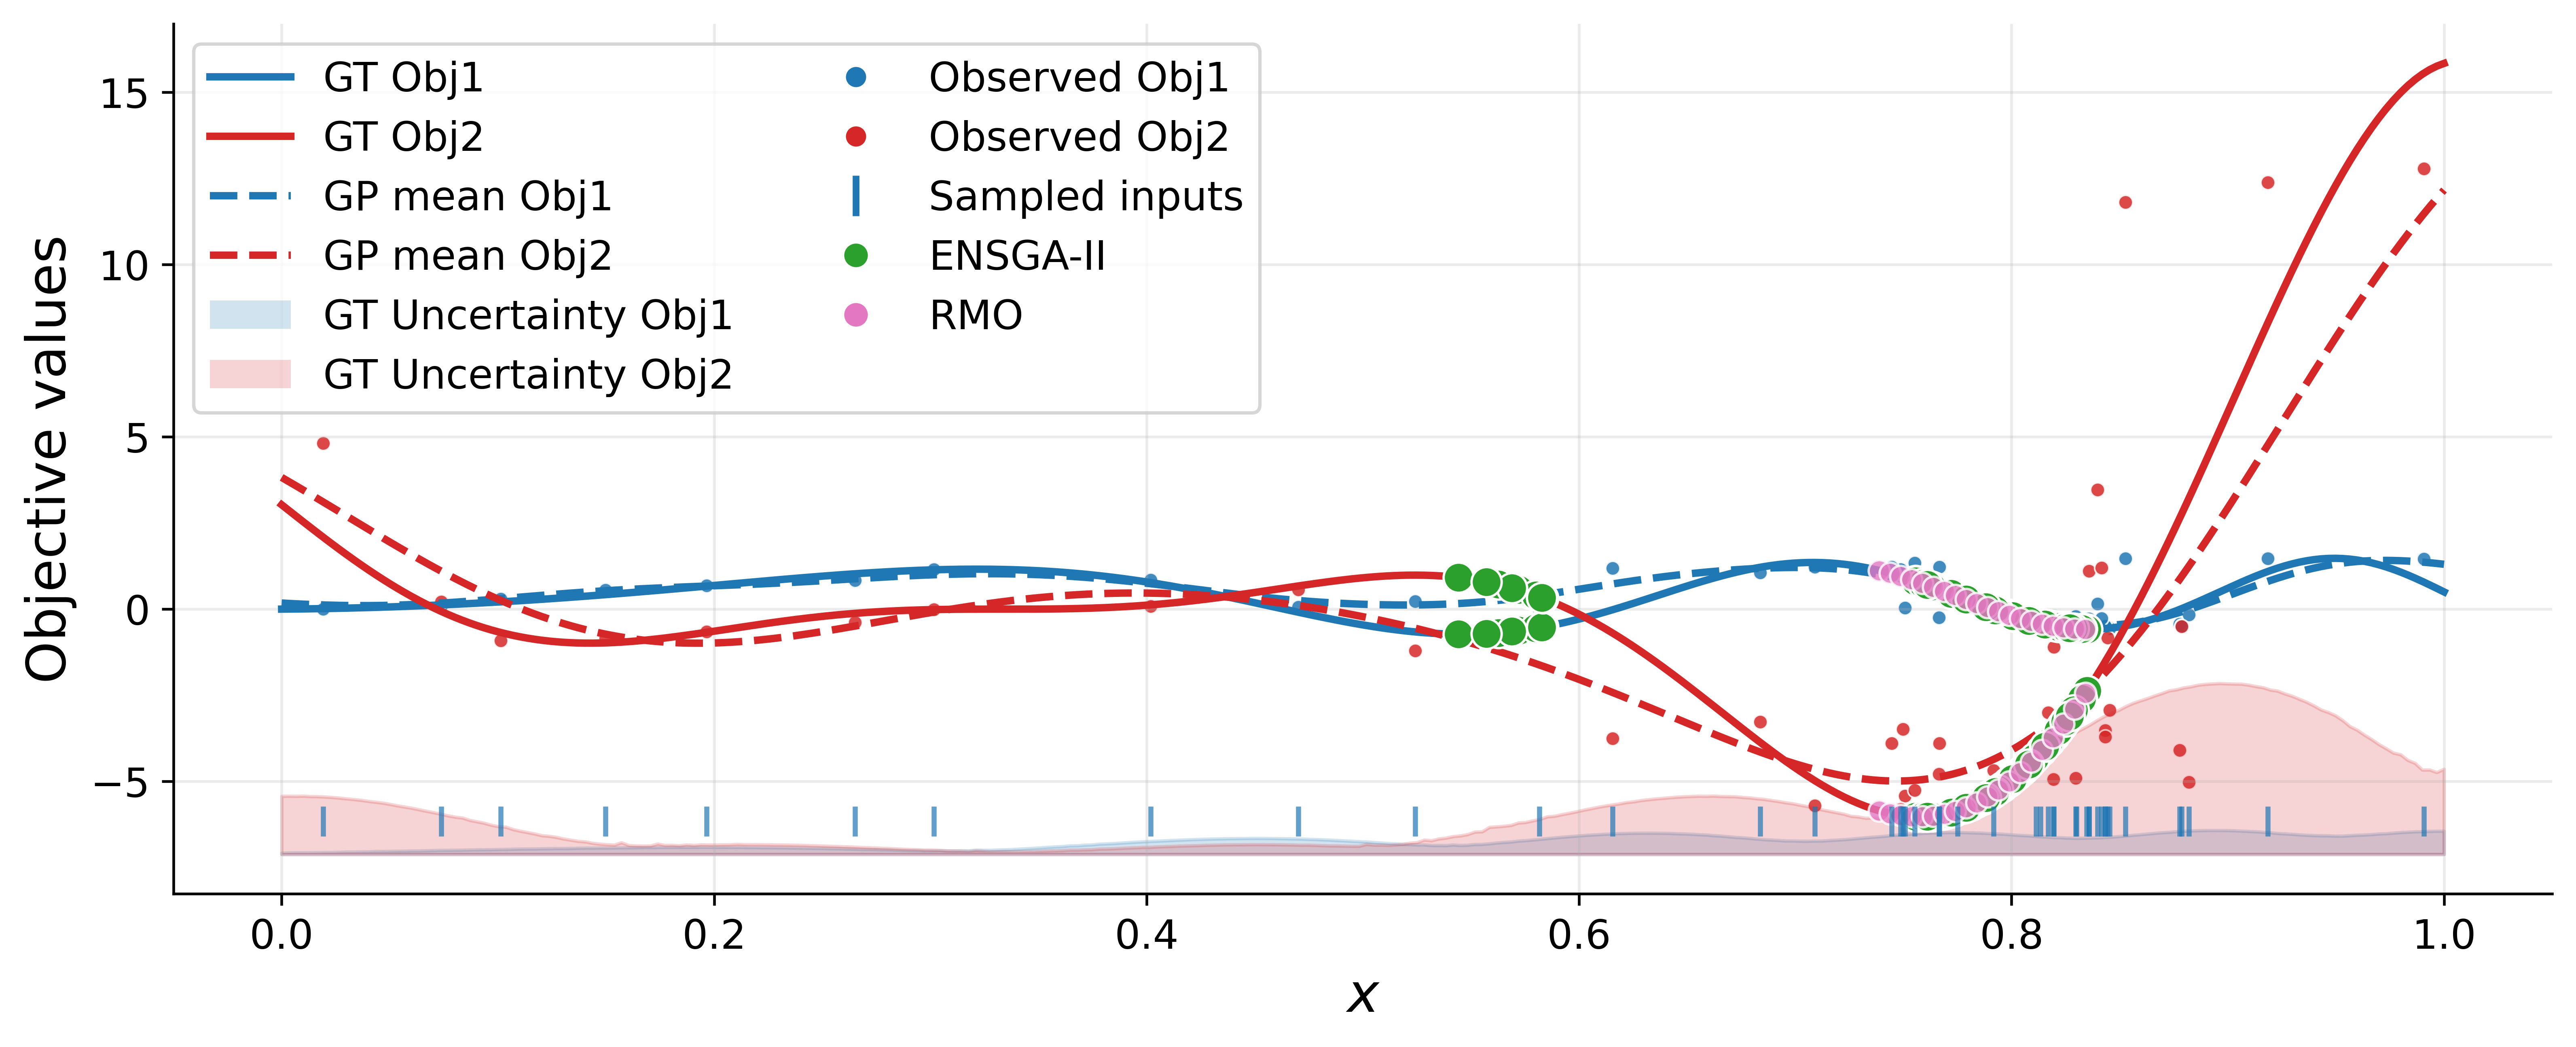

In [224]:
plot_MO_RMO_singlepanel(ARBO_0_t2, pareto_x_0_t2_con5, torch.tensor(large_tau_nsga))

In [156]:
compute_matrics(ARBO_0_t2, pareto_X_5, pareto_x_0_t2_con5, 2000)

{'GD': 0.010078745290374107,
 'IGD': 0.7239559252538404,
 'DeltaHV': 0.23659899380607197}

In [157]:
compute_matrics(ARBO_0_t2, pareto_X_5, large_tau_nsga, 2000)

{'GD': 0.05364378348562551,
 'IGD': 0.033202637883823764,
 'DeltaHV': -0.03669268977139595}

## low tau

In [132]:
pareto_x_0p1_t1_con2, pareto_y_0p1_t1_con2 = get_pareto_front_1d(obj=ARBO_0p1_t1, threshold=2)

Pareto front size: torch.Size([31, 2])


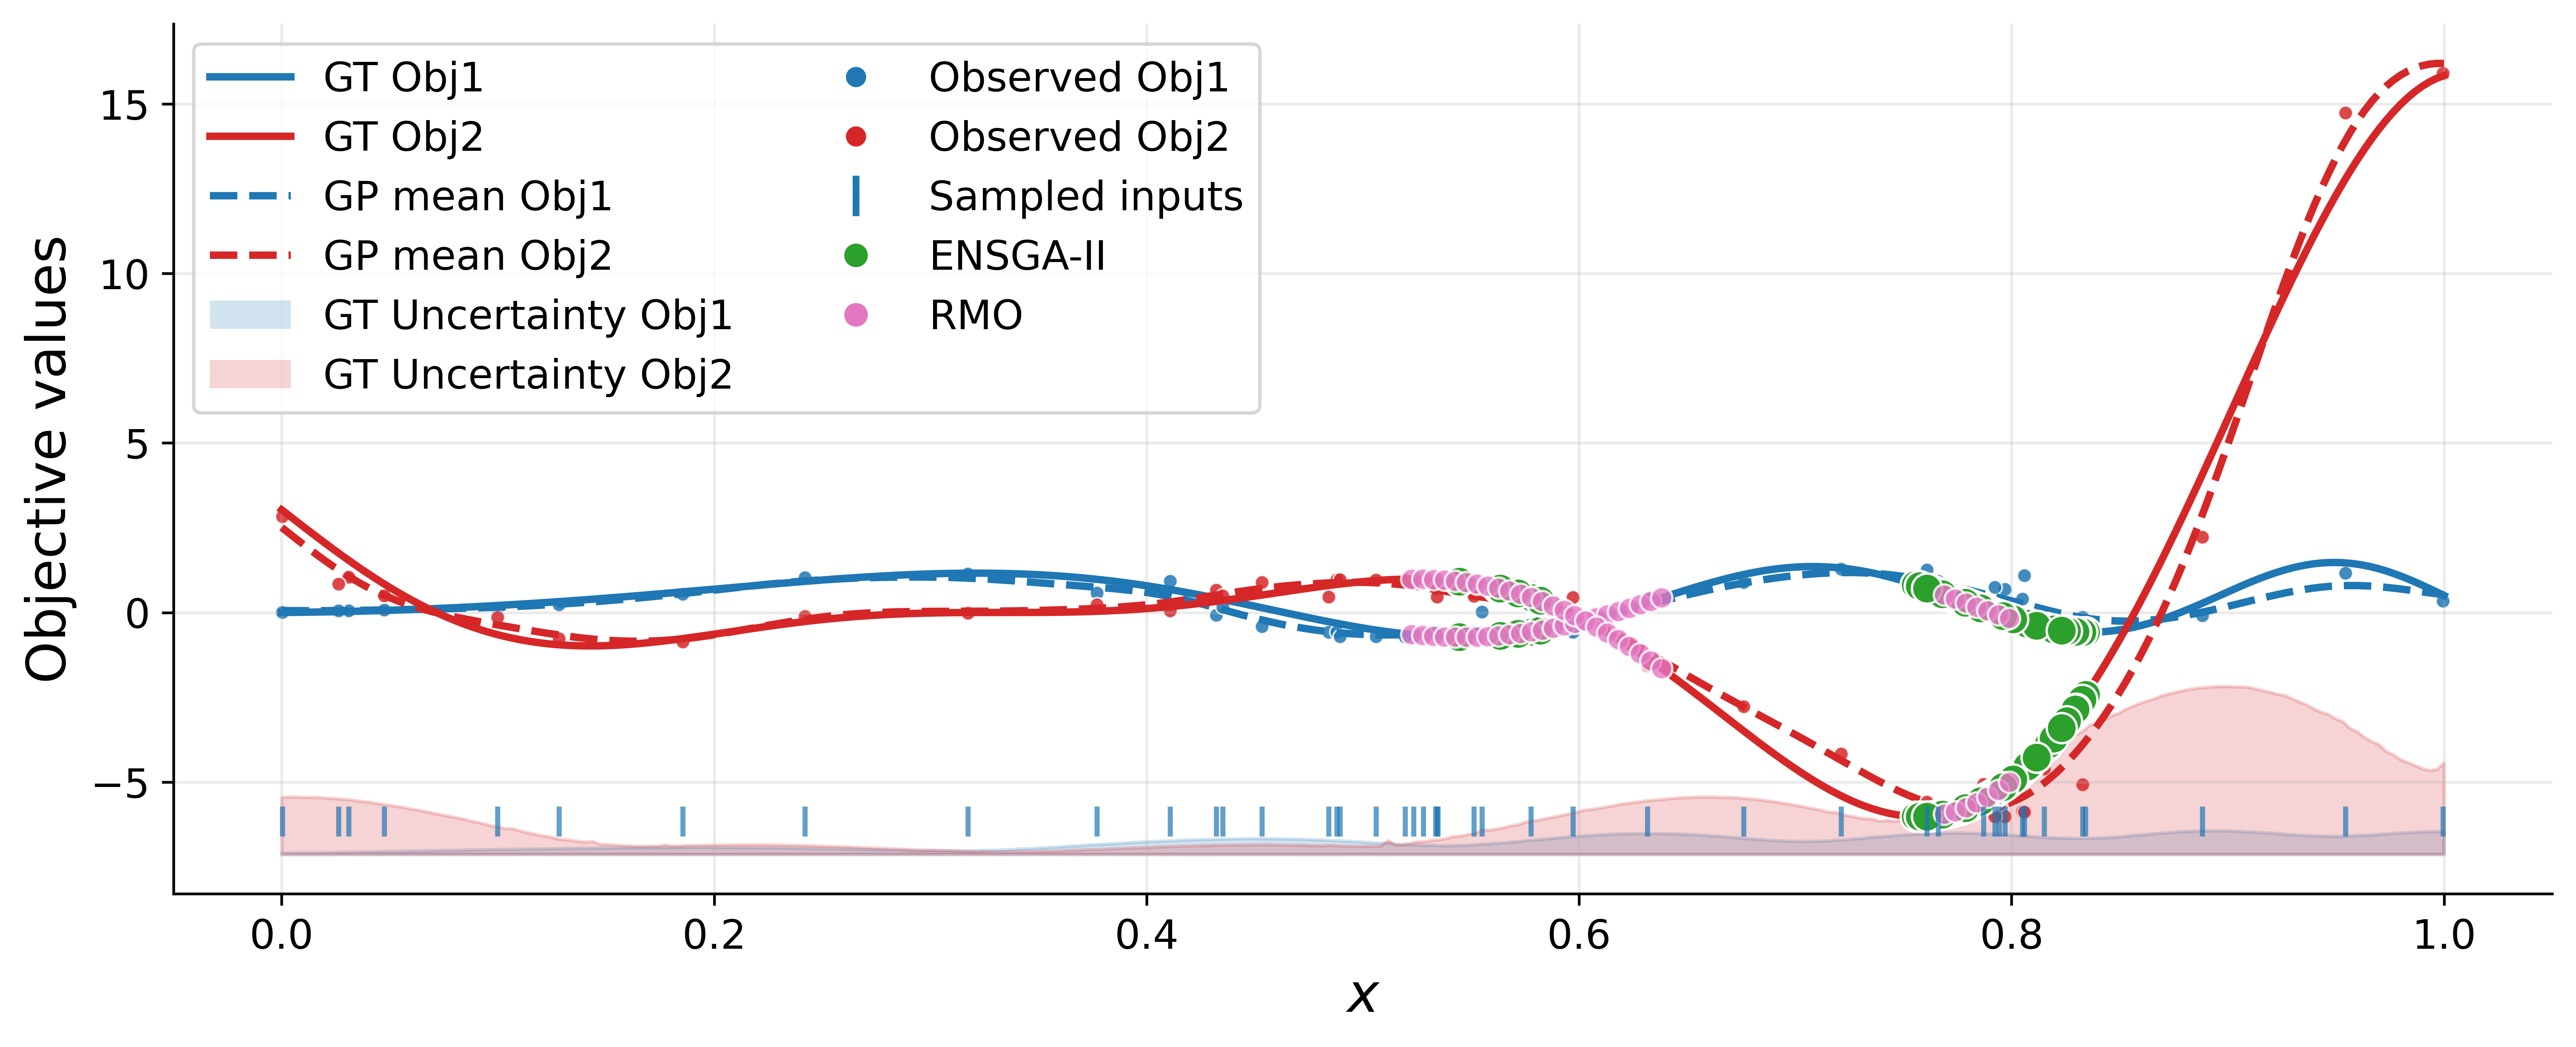

In [225]:
plot_MO_RMO_singlepanel(ARBO_0p1_t1, pareto_x_0p1_t1_con2, torch.tensor(small_tau_nsga))

In [161]:
compute_matrics(ARBO_0_t2, pareto_X_2, pareto_x_0p1_t1_con2, 5000)

{'GD': 0.0923468342132118,
 'IGD': 0.03536842512170559,
 'DeltaHV': 0.2749219944256218}

In [162]:
compute_matrics(ARBO_0_t2, pareto_X_2, small_tau_nsga, 5000)

{'GD': 0.036248186559031885,
 'IGD': 0.018409718046021074,
 'DeltaHV': -0.22458180933575722}